## 3 Sentiment Analysis [40 points]

Sentiment analysis refers to the use of natural language processing to systematically identify, extract, quantify, and study affective states and subjective information. As shown in class it is widely applied to reviews and survey responses, and social media content for applications that range from marketing to customer service. In this problem, we will explore a basic task in sentiment analysis, which is classifying the polarity of a given text to be positive or negative.

For this problem, we will use the training data containing 10,000 Yelp restaurant reviews, where each review is labelled based on their ratings. Reviews for training dataset are in the corresponding folders (‘/neg’ for negative reviews and ‘/pos’ for positive reviews). Label the negative sentiment reviews from the /neg folder as 1 and the positive sentiment reviews from the /pos folder as 0, these 1 and 0 labels will be your target labels for sentiment analysis.

The training data is available at: http://bit.ly/2nuzyUM

You can use the following tools for implementation:
1. TensorFlow https://www.tensorflow.org/
2. Scikit-learn http://scikit-learn.org/stable/index.html
3. PyTorch http://pytorch.org/

In addition to output, results and your answers (in a file named Q3.txt), please submit your code along with a README file explaining how to run your code.

In [1]:
import glob
from sklearn.utils import shuffle
from nltk.tokenize import sent_tokenize, word_tokenize
from collections import Counter
import string
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import gensim
%matplotlib inline

from keras.models import Sequential
from keras.layers import Dense

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD

Using TensorFlow backend.


In [2]:
def load_data(input_directory):
    filenames = []
    data = []
    labels = []
    for filename in glob.glob(input_directory + "/*"):
#         print("Prepocessing: {}".format(file_name))
        filenames.append(filename[filename.rfind('/')+1:])
        file_pointer = open(filename, "r")

        # Read file contents
        file_content = file_pointer.read()
        data.append(file_content)
        file_pointer.close()
        
    # Get the labels
    if input_directory[input_directory.rfind('/')+1:] == 'neg':
        labels = [1] * len(data)
    else:
        labels = [0] * len(data)
    return filenames, data, labels

In [3]:
negative_filenames, negative_data, negative_labels = load_data('../input/training/neg')
positive_filenames, positive_data, positive_labels = load_data('../input/training/pos')
train_filenames = negative_filenames + positive_filenames
train_data = negative_data + positive_data
train_labels = negative_labels + positive_labels
train_filenames, train_data, train_labels = shuffle(train_filenames, train_data, train_labels, random_state=0)

In [4]:
train_data[0:2]

['By far my favorite lunch spot in the entire Phoenix area. The chopped salad & chicken pesto sandwich are my favorite. The desserts are delicious. Try the lunch special and you get an amazing little chocolate chip cookie!',
 'This place is keeping itself in business by promoting weekly and monthly recurring customers.  They play a video about diseases related to back troubles of which 75% would be thrown away by the American Medical Association. Some chiros will help you. They will not. I was told that one visit does nothing and repeat trips are the only way to get relief.  Nice receptionist, but morally bankrupt premise that their business is built on. Not practice. Business.']

In [5]:
len(train_labels)

10000

#### Support Functions

In [6]:
def get_word_tokens(data):
    # Get word tokens - will include {'can't', 'app.'}
    word_tokens = data.split()
    
    # Create a puntuation table
    table = str.maketrans('', '', string.punctuation)
    
    # Remove puntuations, lowercase the word.
    result = []
    for word_token in word_tokens:
        word_token = word_token.strip()
        if (word_token == None) or (word_token == ''):
            continue
        elif word_token in string.punctuation:
            # ",", "."
            continue
        else:
            # For words like "app." --> "app" | "man --> man"
            word_token = word_token.translate(table)
            # Lowercase the word
            word_token = word_token.lower()
        result.append(word_token)
        
    return result

In [7]:
def get_cross_validation_sets(k, train_df):
    result = []
    size = train_df.shape[0]
    each_dev_set_size = int(size/k)
    for i in range(0, size, each_dev_set_size):
        if i == 0:
            result.append({
                'dev': (i, i+each_dev_set_size),
                'train': (i+each_dev_set_size, size),
                'dev_df': train_df.iloc[i:i+each_dev_set_size, :],
                'train_df': train_df.iloc[i+each_dev_set_size:size, :]
            })
        elif (i + each_dev_set_size) == size:
            result.append({
                'dev':(i, i+each_dev_set_size),
                'train': (0, i),
                'dev_df': train_df.iloc[i:i+each_dev_set_size, :],
                'train_df': train_df.iloc[0:i, :]
            })
        else:
            temp_train_df_1 = train_df.iloc[0:i, :]
            temp_train_df_2 = train_df.iloc[i+each_dev_set_size:size, :]
            temp_train_df = pd.concat([temp_train_df_1, temp_train_df_2])
            result.append({
                'dev':(i, i+each_dev_set_size),
                'train': [(0, i), (i+each_dev_set_size, size)],
                'dev_df': train_df.iloc[i:i+each_dev_set_size, :],
                'train_df': temp_train_df
            })
            
    return result

In [8]:
def plot_accuracy(history):
    # Plotting the history of accuracy 
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc = 'upper left')
    plt.show()

In [9]:
def plot_loss(history):
    # Summarizing the history of loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(['Train', 'Test'], loc = 'upper left')
    plt.show()

In [10]:
def get_model_template(input_dimensions, n1, activation_function):
    model = Sequential()
    model.add(Dense(n1, input_dim=input_dimensions, activation=activation_function))
    model.add(Dense(10, activation=activation_function))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [11]:
def train(model, x_train, y_train, x_test=None, y_test=None, save=False, model_name=None):
    model.summary()
    history = None
    if x_test is None:
        ## If validation/test set is not given
        print("Validation/Test set is not given")
        history = model.fit(x_train, y_train, epochs=10, batch_size=64)
    else:
        history = model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=10, batch_size=64)
    
    if save == True:
        model.save('../output/'+model_name+'.h5')
    return model, history

In [12]:
def get_x_y(df):
    x = df[df.columns.difference(['y_label', 'filenameindex'])].values
    y = df[['y_label']].values
    return x,y

In [13]:
def get_parameters(cross_validation_sets, output_filename, neurons_in_layer_1, activation_functions):
    temp_output_file = open(output_filename, 'w')
    temp_output_file.write('############################## \n\n\n')
    input_dimensions = cross_validation_sets[0]['train_df'].shape[1] - 2
    
    max_val_accuracy = 0
    selected_model_parameters = ()
    for n1 in neurons_in_layer_1:
        for activation_function in activation_functions:
            print('Input Dim: {}, n1: {}, n2: {}, activation: {}, activation_output: {} \n'.format(input_dimensions, n1, 10, activation_function, 'sigmoid'))
            temp_output_file.write('Input Dim: {}, n1: {}, n2: {}, activation: {}, activation_output: {} \n'.format(input_dimensions, n1, 10, activation_function, 'sigmoid'))
            cv_val_accuracy_list = []
            for i in range(len(cross_validation_sets)):
                cross_validation_set = cross_validation_sets[i]

                temp_output_file.write('Dev: {}, Trian: {}\n'.format(cross_validation_set['dev'], cross_validation_set['train']))
                print("Dev: {}, Train: {}".format(cross_validation_set['dev'], cross_validation_set['train']))

                train_df = cross_validation_set['train_df']
                train_x_df, train_y_df = get_x_y(train_df)
                dev_df = cross_validation_set['dev_df']
                dev_x_df, dev_y_df = get_x_y(dev_df)
                
                model = get_model_template(train_x_df.shape[1], n1, activation_function)
                model, history = train(model, train_x_df, train_y_df, dev_x_df, dev_y_df)
                plot_accuracy(history)
                plot_loss(history)
                              
                temp_output_file.write('Accuracy -- Dev: {}, Trian: {}\n'.format(history.history['val_accuracy'][-1], history.history['accuracy'][-1]))
                
                cv_val_accuracy_list.append(history.history['val_accuracy'][-1])
                
            mean_avg = sum(cv_val_accuracy_list) / len(cv_val_accuracy_list)
            temp_output_file.write('Accuracy ---- list: {}, mean: {}\n\n'.format(cv_val_accuracy_list, mean_avg))
            
            # Checking for best parameter
            if mean_avg > max_val_accuracy:
                max_val_accuracy = mean_avg
                selected_model_parameters = {
                    'val_accuracy':max_val_accuracy,
                    'n1': n1,
                    'n2': 10,
                    'activation': activation_function,
                    'n2_activation': 'sigmoid'
                }
     
    temp_output_file.write('Selected parameters: {}\n\n'.format(selected_model_parameters))
    temp_output_file.close()                              
    return selected_model_parameters                        

### 3.3 [8 points]
Use pre-trained word embeddings GoogleNews-vectors-negative300.bin.gz from Word2vec https://code.google.com/archive/p/word2vec/, and compute the review feature vector by using the average word embeddings. Do the same as described in 3.1: Use 10-fold cross-validation to optimize any parameters (e.g. activation function or number of nodes in the first hidden layer). Use accuracy as the metric for parameter selection. Report the parameters of your best model. Then re-train the best performing model on the whole training set, and report the accuracy on the same training set.

In [14]:
def get_word_2_vec_model(filepath):
    model = gensim.models.KeyedVectors.load_word2vec_format(filepath, binary=True)
    return model

In [15]:
word_2_vec_model = get_word_2_vec_model('../input/GoogleNews-vectors-negative300.bin')

In [16]:
## get word2vec for each sentences by using average word embeddings
def word2vec_vectors(word_2_vec, data):
    vector_dict = {}
    for i in range(len(data)):
        if i % 1000 == 0:
            print("Processing row: {}".format(i))
        sentence_vector = np.array([0.0 for i in range(0, 300)])
        # Get word tokens
        word_tokens = get_word_tokens(data[i])
        for token in word_tokens:
            if token in word_2_vec.vocab:
                token_vector = word_2_vec.get_vector(token)
                sentence_vector = sentence_vector + token_vector
            else:
                # Word not present in the word_2_vec model
                continue
                
        ## Sum all the vectors and get the average
        average_vector = sentence_vector/len(word_tokens)
        vector_dict[i] = average_vector
    
    # Create a dataframe from dict
    df = pd.DataFrame.from_dict(vector_dict, orient='index')
    return df

In [17]:
# Get best parameters
def run_3_3_1(train_df):
    print("Getting validation sets")
    cross_validation_sets = get_cross_validation_sets(10, train_df)
    output_filename = '../output/word_2_vect_training.txt'
    activation_functions = ['relu', 'sigmoid', 'tanh']
    neurons_in_layer_1 = [5, 8, 10]
    print("Getting Best parameters")
    selected_model_parameters = get_parameters(cross_validation_sets, output_filename, neurons_in_layer_1, activation_functions)
    return selected_model_parameters

In [18]:
def run_3_3_2(train_df, selected_model_parameters):
    temp_output_file = open('../output/word_2_vect_result.txt', 'w')
    temp_output_file.write('Selected Parameters: {}\n\n'.format(selected_model_parameters))
    train_x_df, train_y_df = get_x_y(train_df)
    model = get_model_template(train_x_df.shape[1], selected_model_parameters['n1'], selected_model_parameters['activation'])
    model, history = train(model, train_x_df, train_y_df, None, None, True, 'word_2_vec')
    temp_output_file.write('Train Accuracy: {}\n\n'.format(history.history['accuracy'][-1]))

In [19]:
def run_3_3(word_2_vec, train_data, train_labels):
    print("Getting the dataframe")
    train_df = word2vec_vectors(word_2_vec_model, train_data)
    train_df['y_label'] = train_labels
    train_df['filenameindex'] = train_filenames

    print("Training for the whole train dataset")
    selected_model_parameters = run_3_3_1(train_df)
    run_3_3_2(train_df, selected_model_parameters)

Getting the dataframe
Processing row: 0
Processing row: 1000
Processing row: 2000
Processing row: 3000
Processing row: 4000
Processing row: 5000
Processing row: 6000
Processing row: 7000
Processing row: 8000
Processing row: 9000
Training for the whole train dataset
Getting validation sets
Getting Best parameters
Input Dim: 300, n1: 5, n2: 10, activation: relu, activation_output: sigmoid 

Dev: (0, 1000), Train: (1000, 10000)
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 5)                 1505      
_________________________________________________________________
dense_2 (Dense)              (None, 10)                60        
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 11        
Total params: 1,576
Trainable params: 1,576
Non-trainable params: 0
___________________

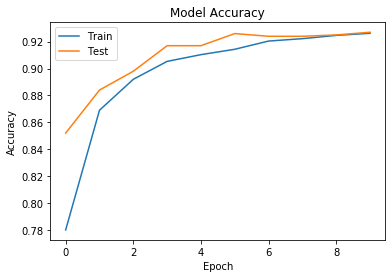

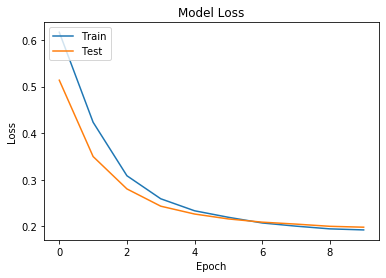

Dev: (1000, 2000), Train: [(0, 1000), (2000, 10000)]
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 5)                 1505      
_________________________________________________________________
dense_5 (Dense)              (None, 10)                60        
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 11        
Total params: 1,576
Trainable params: 1,576
Non-trainable params: 0
_________________________________________________________________
Train on 9000 samples, validate on 1000 samples
Epoch 1/10
9000/9000 [==============================] - 1s 61us/step - loss: 0.6473 - accuracy: 0.7191 - val_loss: 0.5649 - val_accuracy: 0.8310
Epoch 2/10
9000/9000 [==============================] - 0s 30us/step - loss: 0.4515 - accuracy: 0.8691 - val_loss: 0.3594 - val_accuracy

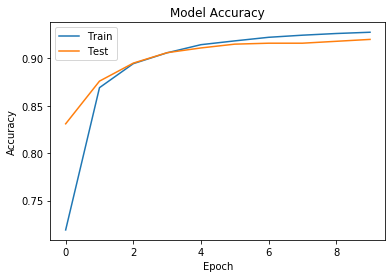

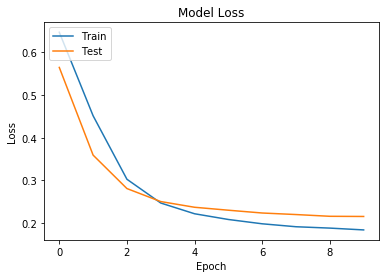

Dev: (2000, 3000), Train: [(0, 2000), (3000, 10000)]
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_7 (Dense)              (None, 5)                 1505      
_________________________________________________________________
dense_8 (Dense)              (None, 10)                60        
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 11        
Total params: 1,576
Trainable params: 1,576
Non-trainable params: 0
_________________________________________________________________
Train on 9000 samples, validate on 1000 samples
Epoch 1/10
9000/9000 [==============================] - 0s 55us/step - loss: 0.6302 - accuracy: 0.7877 - val_loss: 0.5380 - val_accuracy: 0.8440
Epoch 2/10
9000/9000 [==============================] - 0s 32us/step - loss: 0.4144 - accuracy: 0.8789 - val_loss: 0.3467 - val_accuracy

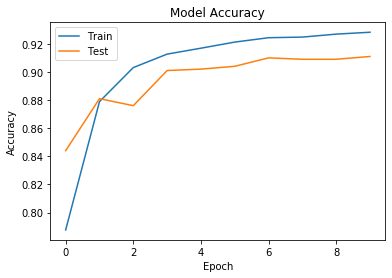

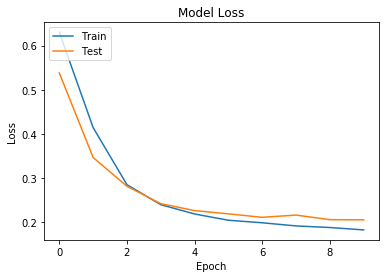

Dev: (3000, 4000), Train: [(0, 3000), (4000, 10000)]
Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_10 (Dense)             (None, 5)                 1505      
_________________________________________________________________
dense_11 (Dense)             (None, 10)                60        
_________________________________________________________________
dense_12 (Dense)             (None, 1)                 11        
Total params: 1,576
Trainable params: 1,576
Non-trainable params: 0
_________________________________________________________________
Train on 9000 samples, validate on 1000 samples
Epoch 1/10
9000/9000 [==============================] - 0s 41us/step - loss: 0.6430 - accuracy: 0.7527 - val_loss: 0.5584 - val_accuracy: 0.8340
Epoch 2/10
9000/9000 [==============================] - 0s 23us/step - loss: 0.4562 - accuracy: 0.8681 - val_loss: 0.3682 - val_accuracy

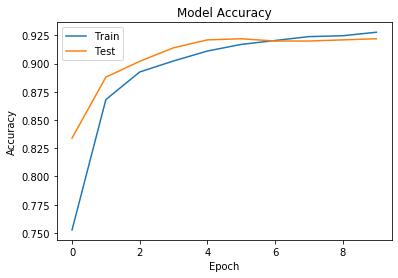

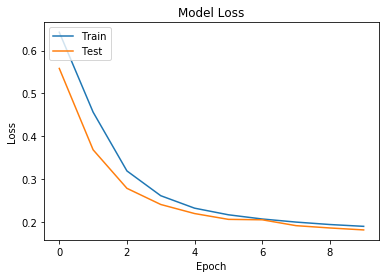

Dev: (4000, 5000), Train: [(0, 4000), (5000, 10000)]
Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_13 (Dense)             (None, 5)                 1505      
_________________________________________________________________
dense_14 (Dense)             (None, 10)                60        
_________________________________________________________________
dense_15 (Dense)             (None, 1)                 11        
Total params: 1,576
Trainable params: 1,576
Non-trainable params: 0
_________________________________________________________________
Train on 9000 samples, validate on 1000 samples
Epoch 1/10
9000/9000 [==============================] - 0s 44us/step - loss: 0.6588 - accuracy: 0.6912 - val_loss: 0.5930 - val_accuracy: 0.8590
Epoch 2/10
9000/9000 [==============================] - 0s 22us/step - loss: 0.4943 - accuracy: 0.8622 - val_loss: 0.3923 - val_accuracy

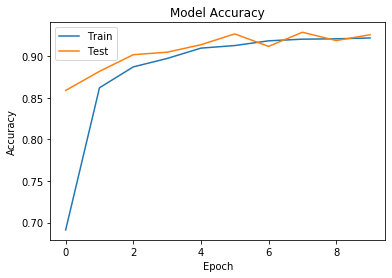

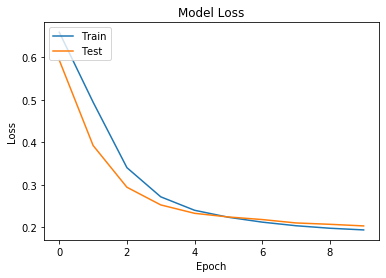

Dev: (5000, 6000), Train: [(0, 5000), (6000, 10000)]
Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_16 (Dense)             (None, 5)                 1505      
_________________________________________________________________
dense_17 (Dense)             (None, 10)                60        
_________________________________________________________________
dense_18 (Dense)             (None, 1)                 11        
Total params: 1,576
Trainable params: 1,576
Non-trainable params: 0
_________________________________________________________________
Train on 9000 samples, validate on 1000 samples
Epoch 1/10
9000/9000 [==============================] - 0s 54us/step - loss: 0.6578 - accuracy: 0.6339 - val_loss: 0.6061 - val_accuracy: 0.7330
Epoch 2/10
9000/9000 [==============================] - 0s 29us/step - loss: 0.5177 - accuracy: 0.8263 - val_loss: 0.4264 - val_accuracy

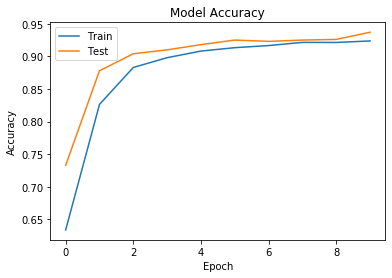

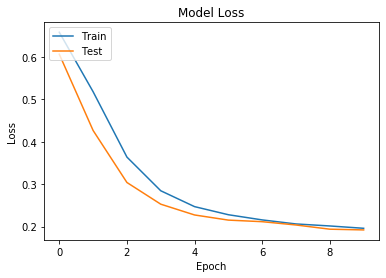

Dev: (6000, 7000), Train: [(0, 6000), (7000, 10000)]
Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_19 (Dense)             (None, 5)                 1505      
_________________________________________________________________
dense_20 (Dense)             (None, 10)                60        
_________________________________________________________________
dense_21 (Dense)             (None, 1)                 11        
Total params: 1,576
Trainable params: 1,576
Non-trainable params: 0
_________________________________________________________________
Train on 9000 samples, validate on 1000 samples
Epoch 1/10
9000/9000 [==============================] - 1s 60us/step - loss: 0.6601 - accuracy: 0.7167 - val_loss: 0.5978 - val_accuracy: 0.8040
Epoch 2/10
9000/9000 [==============================] - 0s 35us/step - loss: 0.4979 - accuracy: 0.8586 - val_loss: 0.4097 - val_accuracy

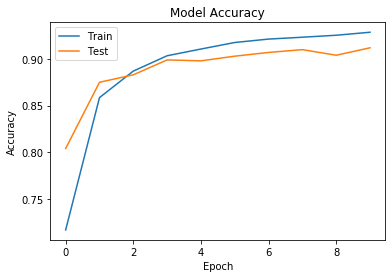

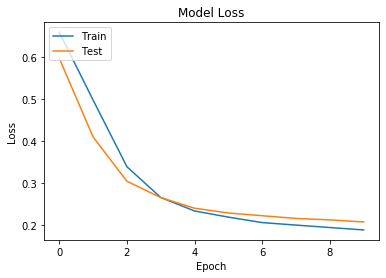

Dev: (7000, 8000), Train: [(0, 7000), (8000, 10000)]
Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_22 (Dense)             (None, 5)                 1505      
_________________________________________________________________
dense_23 (Dense)             (None, 10)                60        
_________________________________________________________________
dense_24 (Dense)             (None, 1)                 11        
Total params: 1,576
Trainable params: 1,576
Non-trainable params: 0
_________________________________________________________________
Train on 9000 samples, validate on 1000 samples
Epoch 1/10
9000/9000 [==============================] - 1s 57us/step - loss: 0.6383 - accuracy: 0.7201 - val_loss: 0.5470 - val_accuracy: 0.8570
Epoch 2/10
9000/9000 [==============================] - 0s 31us/step - loss: 0.4344 - accuracy: 0.8791 - val_loss: 0.3419 - val_accuracy

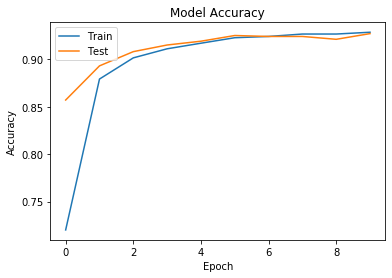

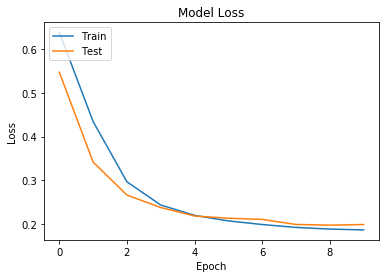

Dev: (8000, 9000), Train: [(0, 8000), (9000, 10000)]
Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_25 (Dense)             (None, 5)                 1505      
_________________________________________________________________
dense_26 (Dense)             (None, 10)                60        
_________________________________________________________________
dense_27 (Dense)             (None, 1)                 11        
Total params: 1,576
Trainable params: 1,576
Non-trainable params: 0
_________________________________________________________________
Train on 9000 samples, validate on 1000 samples
Epoch 1/10
9000/9000 [==============================] - 1s 58us/step - loss: 0.6325 - accuracy: 0.7083 - val_loss: 0.5382 - val_accuracy: 0.8390
Epoch 2/10
9000/9000 [==============================] - 0s 34us/step - loss: 0.4285 - accuracy: 0.8716 - val_loss: 0.3476 - val_accuracy

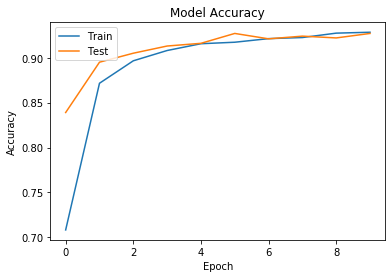

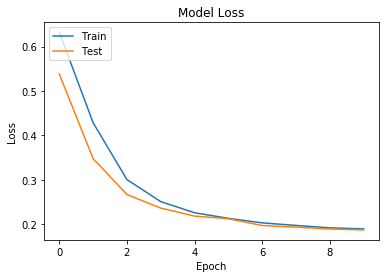

Dev: (9000, 10000), Train: (0, 9000)
Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_28 (Dense)             (None, 5)                 1505      
_________________________________________________________________
dense_29 (Dense)             (None, 10)                60        
_________________________________________________________________
dense_30 (Dense)             (None, 1)                 11        
Total params: 1,576
Trainable params: 1,576
Non-trainable params: 0
_________________________________________________________________
Train on 9000 samples, validate on 1000 samples
Epoch 1/10
9000/9000 [==============================] - 1s 59us/step - loss: 0.6379 - accuracy: 0.7419 - val_loss: 0.5502 - val_accuracy: 0.8340
Epoch 2/10
9000/9000 [==============================] - 0s 34us/step - loss: 0.4669 - accuracy: 0.8700 - val_loss: 0.3699 - val_accuracy: 0.8920
Epoch 

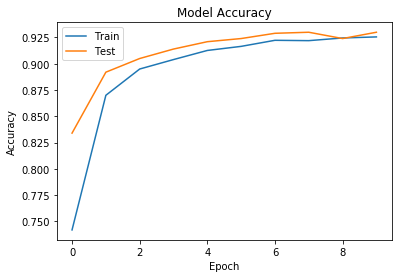

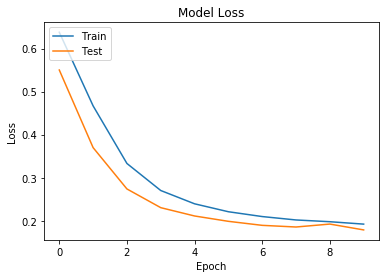

Input Dim: 300, n1: 5, n2: 10, activation: sigmoid, activation_output: sigmoid 

Dev: (0, 1000), Train: (1000, 10000)
Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_31 (Dense)             (None, 5)                 1505      
_________________________________________________________________
dense_32 (Dense)             (None, 10)                60        
_________________________________________________________________
dense_33 (Dense)             (None, 1)                 11        
Total params: 1,576
Trainable params: 1,576
Non-trainable params: 0
_________________________________________________________________
Train on 9000 samples, validate on 1000 samples
Epoch 1/10
9000/9000 [==============================] - 1s 56us/step - loss: 0.6944 - accuracy: 0.5151 - val_loss: 0.6905 - val_accuracy: 0.5780
Epoch 2/10
9000/9000 [==============================] - 0s 32us/step -

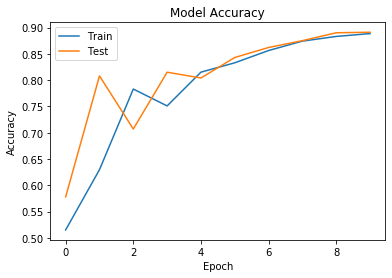

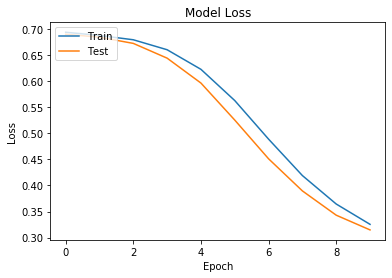

Dev: (1000, 2000), Train: [(0, 1000), (2000, 10000)]
Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_34 (Dense)             (None, 5)                 1505      
_________________________________________________________________
dense_35 (Dense)             (None, 10)                60        
_________________________________________________________________
dense_36 (Dense)             (None, 1)                 11        
Total params: 1,576
Trainable params: 1,576
Non-trainable params: 0
_________________________________________________________________
Train on 9000 samples, validate on 1000 samples
Epoch 1/10
9000/9000 [==============================] - 1s 57us/step - loss: 0.7024 - accuracy: 0.5066 - val_loss: 0.6887 - val_accuracy: 0.5810
Epoch 2/10
9000/9000 [==============================] - 0s 31us/step - loss: 0.6851 - accuracy: 0.7039 - val_loss: 0.6795 - val_accurac

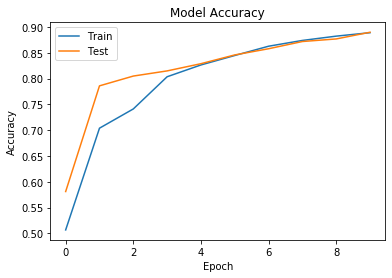

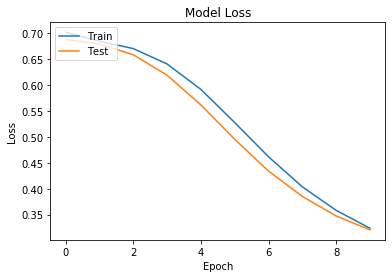

Dev: (2000, 3000), Train: [(0, 2000), (3000, 10000)]
Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_37 (Dense)             (None, 5)                 1505      
_________________________________________________________________
dense_38 (Dense)             (None, 10)                60        
_________________________________________________________________
dense_39 (Dense)             (None, 1)                 11        
Total params: 1,576
Trainable params: 1,576
Non-trainable params: 0
_________________________________________________________________
Train on 9000 samples, validate on 1000 samples
Epoch 1/10
9000/9000 [==============================] - 1s 63us/step - loss: 0.6979 - accuracy: 0.5226 - val_loss: 0.6891 - val_accuracy: 0.4810
Epoch 2/10
9000/9000 [==============================] - 0s 34us/step - loss: 0.6843 - accuracy: 0.6846 - val_loss: 0.6798 - val_accurac

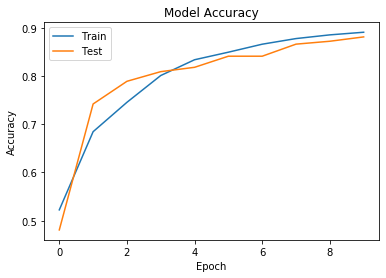

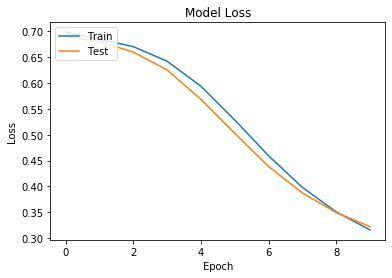

Dev: (3000, 4000), Train: [(0, 3000), (4000, 10000)]
Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_40 (Dense)             (None, 5)                 1505      
_________________________________________________________________
dense_41 (Dense)             (None, 10)                60        
_________________________________________________________________
dense_42 (Dense)             (None, 1)                 11        
Total params: 1,576
Trainable params: 1,576
Non-trainable params: 0
_________________________________________________________________
Train on 9000 samples, validate on 1000 samples
Epoch 1/10
9000/9000 [==============================] - 1s 56us/step - loss: 0.7137 - accuracy: 0.5020 - val_loss: 0.6923 - val_accuracy: 0.4820
Epoch 2/10
9000/9000 [==============================] - 0s 32us/step - loss: 0.6882 - accuracy: 0.6639 - val_loss: 0.6850 - val_accurac

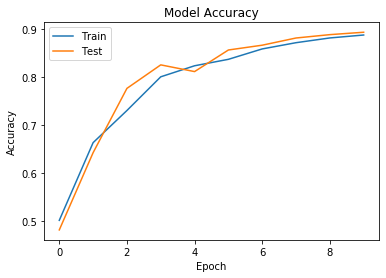

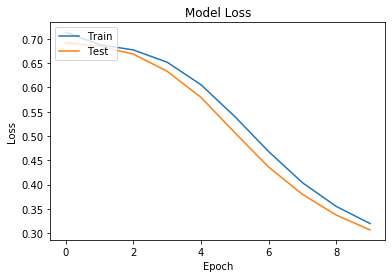

Dev: (4000, 5000), Train: [(0, 4000), (5000, 10000)]
Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_43 (Dense)             (None, 5)                 1505      
_________________________________________________________________
dense_44 (Dense)             (None, 10)                60        
_________________________________________________________________
dense_45 (Dense)             (None, 1)                 11        
Total params: 1,576
Trainable params: 1,576
Non-trainable params: 0
_________________________________________________________________
Train on 9000 samples, validate on 1000 samples
Epoch 1/10
9000/9000 [==============================] - 1s 61us/step - loss: 0.7026 - accuracy: 0.4990 - val_loss: 0.6896 - val_accuracy: 0.5440
Epoch 2/10
9000/9000 [==============================] - 0s 28us/step - loss: 0.6868 - accuracy: 0.7050 - val_loss: 0.6821 - val_accurac

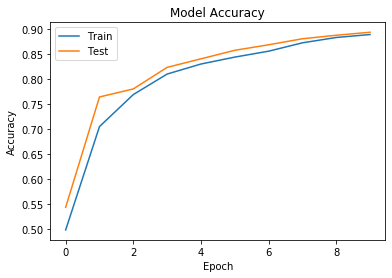

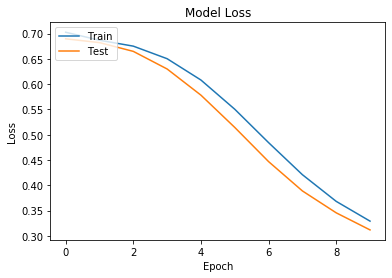

Dev: (5000, 6000), Train: [(0, 5000), (6000, 10000)]
Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_46 (Dense)             (None, 5)                 1505      
_________________________________________________________________
dense_47 (Dense)             (None, 10)                60        
_________________________________________________________________
dense_48 (Dense)             (None, 1)                 11        
Total params: 1,576
Trainable params: 1,576
Non-trainable params: 0
_________________________________________________________________
Train on 9000 samples, validate on 1000 samples
Epoch 1/10
9000/9000 [==============================] - 0s 42us/step - loss: 0.6959 - accuracy: 0.5286 - val_loss: 0.6905 - val_accuracy: 0.6380
Epoch 2/10
9000/9000 [==============================] - 0s 23us/step - loss: 0.6876 - accuracy: 0.6204 - val_loss: 0.6821 - val_accurac

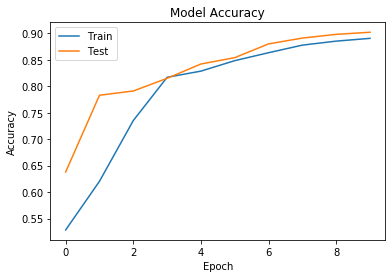

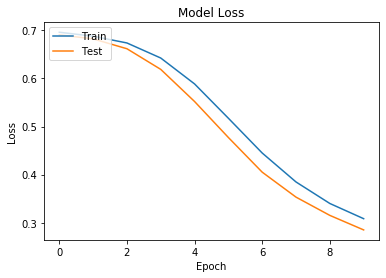

Dev: (6000, 7000), Train: [(0, 6000), (7000, 10000)]
Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_49 (Dense)             (None, 5)                 1505      
_________________________________________________________________
dense_50 (Dense)             (None, 10)                60        
_________________________________________________________________
dense_51 (Dense)             (None, 1)                 11        
Total params: 1,576
Trainable params: 1,576
Non-trainable params: 0
_________________________________________________________________
Train on 9000 samples, validate on 1000 samples
Epoch 1/10
9000/9000 [==============================] - 1s 63us/step - loss: 0.6982 - accuracy: 0.5308 - val_loss: 0.6900 - val_accuracy: 0.6930
Epoch 2/10
9000/9000 [==============================] - 0s 35us/step - loss: 0.6872 - accuracy: 0.6048 - val_loss: 0.6827 - val_accurac

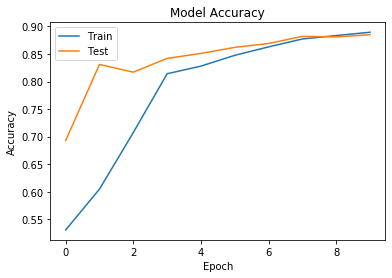

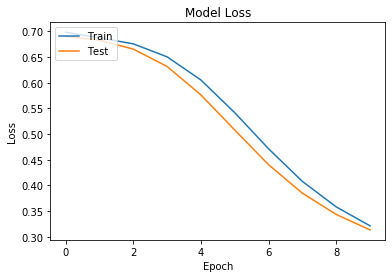

Dev: (7000, 8000), Train: [(0, 7000), (8000, 10000)]
Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_52 (Dense)             (None, 5)                 1505      
_________________________________________________________________
dense_53 (Dense)             (None, 10)                60        
_________________________________________________________________
dense_54 (Dense)             (None, 1)                 11        
Total params: 1,576
Trainable params: 1,576
Non-trainable params: 0
_________________________________________________________________
Train on 9000 samples, validate on 1000 samples
Epoch 1/10
9000/9000 [==============================] - 0s 48us/step - loss: 0.7320 - accuracy: 0.5028 - val_loss: 0.6979 - val_accuracy: 0.4750
Epoch 2/10
9000/9000 [==============================] - 0s 29us/step - loss: 0.6899 - accuracy: 0.5622 - val_loss: 0.6869 - val_accurac

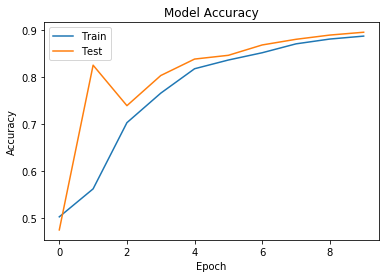

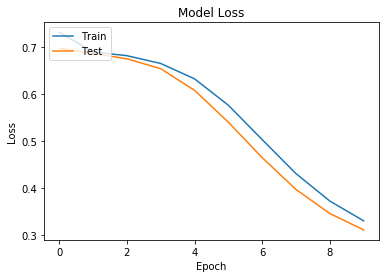

Dev: (8000, 9000), Train: [(0, 8000), (9000, 10000)]
Model: "sequential_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_55 (Dense)             (None, 5)                 1505      
_________________________________________________________________
dense_56 (Dense)             (None, 10)                60        
_________________________________________________________________
dense_57 (Dense)             (None, 1)                 11        
Total params: 1,576
Trainable params: 1,576
Non-trainable params: 0
_________________________________________________________________
Train on 9000 samples, validate on 1000 samples
Epoch 1/10
9000/9000 [==============================] - 0s 40us/step - loss: 0.7374 - accuracy: 0.5023 - val_loss: 0.6996 - val_accuracy: 0.4790
Epoch 2/10
9000/9000 [==============================] - 0s 21us/step - loss: 0.6909 - accuracy: 0.5029 - val_loss: 0.6893 - val_accurac

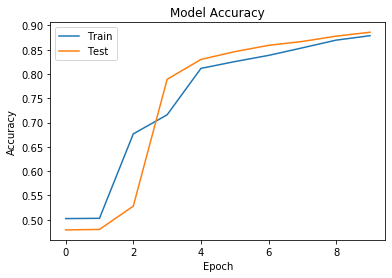

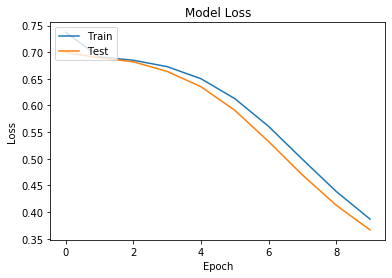

Dev: (9000, 10000), Train: (0, 9000)
Model: "sequential_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_58 (Dense)             (None, 5)                 1505      
_________________________________________________________________
dense_59 (Dense)             (None, 10)                60        
_________________________________________________________________
dense_60 (Dense)             (None, 1)                 11        
Total params: 1,576
Trainable params: 1,576
Non-trainable params: 0
_________________________________________________________________
Train on 9000 samples, validate on 1000 samples
Epoch 1/10
9000/9000 [==============================] - 1s 57us/step - loss: 0.6903 - accuracy: 0.5510 - val_loss: 0.6864 - val_accuracy: 0.7550
Epoch 2/10
9000/9000 [==============================] - 0s 30us/step - loss: 0.6812 - accuracy: 0.7367 - val_loss: 0.6727 - val_accuracy: 0.7550
Epoch 

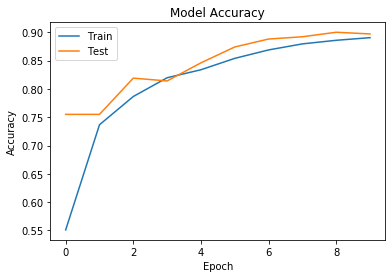

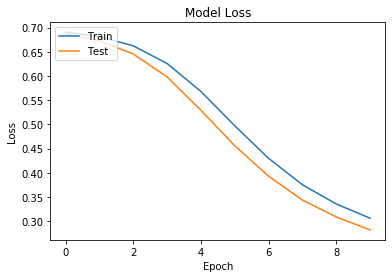

Input Dim: 300, n1: 5, n2: 10, activation: tanh, activation_output: sigmoid 

Dev: (0, 1000), Train: (1000, 10000)
Model: "sequential_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_61 (Dense)             (None, 5)                 1505      
_________________________________________________________________
dense_62 (Dense)             (None, 10)                60        
_________________________________________________________________
dense_63 (Dense)             (None, 1)                 11        
Total params: 1,576
Trainable params: 1,576
Non-trainable params: 0
_________________________________________________________________
Train on 9000 samples, validate on 1000 samples
Epoch 1/10
9000/9000 [==============================] - 1s 56us/step - loss: 0.6267 - accuracy: 0.7704 - val_loss: 0.5112 - val_accuracy: 0.8260
Epoch 2/10
9000/9000 [==============================] - 0s 34us/step - lo

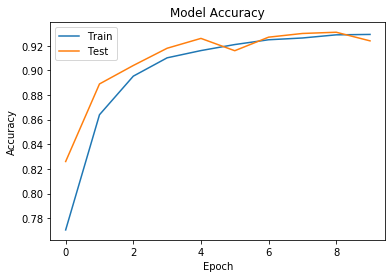

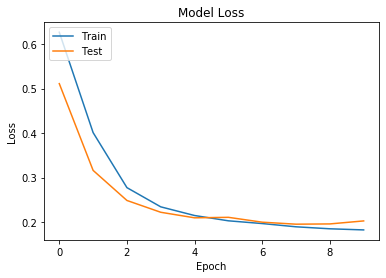

Dev: (1000, 2000), Train: [(0, 1000), (2000, 10000)]
Model: "sequential_22"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_64 (Dense)             (None, 5)                 1505      
_________________________________________________________________
dense_65 (Dense)             (None, 10)                60        
_________________________________________________________________
dense_66 (Dense)             (None, 1)                 11        
Total params: 1,576
Trainable params: 1,576
Non-trainable params: 0
_________________________________________________________________
Train on 9000 samples, validate on 1000 samples
Epoch 1/10
9000/9000 [==============================] - 1s 64us/step - loss: 0.6110 - accuracy: 0.7888 - val_loss: 0.4880 - val_accuracy: 0.8450
Epoch 2/10
9000/9000 [==============================] - 0s 31us/step - loss: 0.3783 - accuracy: 0.8759 - val_loss: 0.3152 - val_accurac

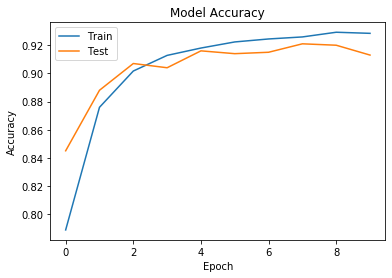

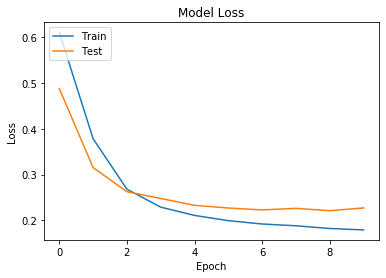

Dev: (2000, 3000), Train: [(0, 2000), (3000, 10000)]
Model: "sequential_23"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_67 (Dense)             (None, 5)                 1505      
_________________________________________________________________
dense_68 (Dense)             (None, 10)                60        
_________________________________________________________________
dense_69 (Dense)             (None, 1)                 11        
Total params: 1,576
Trainable params: 1,576
Non-trainable params: 0
_________________________________________________________________
Train on 9000 samples, validate on 1000 samples
Epoch 1/10
9000/9000 [==============================] - 1s 59us/step - loss: 0.6275 - accuracy: 0.7222 - val_loss: 0.5067 - val_accuracy: 0.8280
Epoch 2/10
9000/9000 [==============================] - 0s 35us/step - loss: 0.3814 - accuracy: 0.8723 - val_loss: 0.3174 - val_accurac

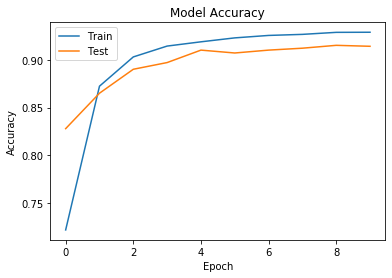

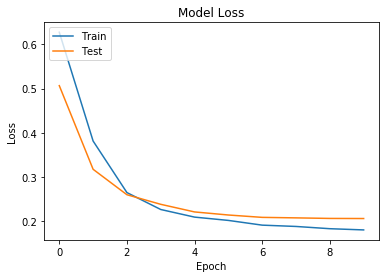

Dev: (3000, 4000), Train: [(0, 3000), (4000, 10000)]
Model: "sequential_24"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_70 (Dense)             (None, 5)                 1505      
_________________________________________________________________
dense_71 (Dense)             (None, 10)                60        
_________________________________________________________________
dense_72 (Dense)             (None, 1)                 11        
Total params: 1,576
Trainable params: 1,576
Non-trainable params: 0
_________________________________________________________________
Train on 9000 samples, validate on 1000 samples
Epoch 1/10
9000/9000 [==============================] - 1s 62us/step - loss: 0.6293 - accuracy: 0.7228 - val_loss: 0.5058 - val_accuracy: 0.8440
Epoch 2/10
9000/9000 [==============================] - 0s 36us/step - loss: 0.3906 - accuracy: 0.8664 - val_loss: 0.3063 - val_accurac

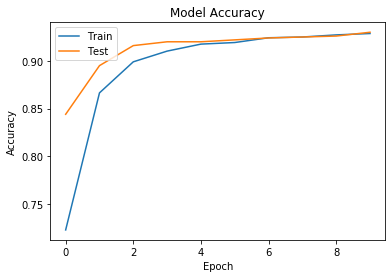

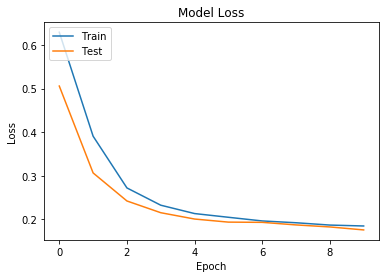

Dev: (4000, 5000), Train: [(0, 4000), (5000, 10000)]
Model: "sequential_25"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_73 (Dense)             (None, 5)                 1505      
_________________________________________________________________
dense_74 (Dense)             (None, 10)                60        
_________________________________________________________________
dense_75 (Dense)             (None, 1)                 11        
Total params: 1,576
Trainable params: 1,576
Non-trainable params: 0
_________________________________________________________________
Train on 9000 samples, validate on 1000 samples
Epoch 1/10
9000/9000 [==============================] - 1s 60us/step - loss: 0.6278 - accuracy: 0.7538 - val_loss: 0.4981 - val_accuracy: 0.8480
Epoch 2/10
9000/9000 [==============================] - 0s 30us/step - loss: 0.3916 - accuracy: 0.8684 - val_loss: 0.3069 - val_accurac

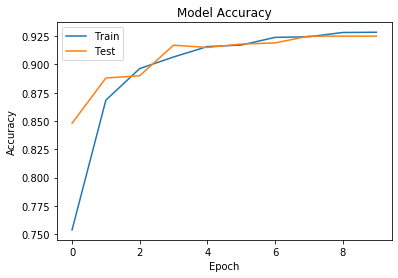

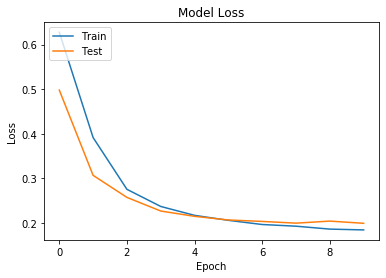

Dev: (5000, 6000), Train: [(0, 5000), (6000, 10000)]
Model: "sequential_26"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_76 (Dense)             (None, 5)                 1505      
_________________________________________________________________
dense_77 (Dense)             (None, 10)                60        
_________________________________________________________________
dense_78 (Dense)             (None, 1)                 11        
Total params: 1,576
Trainable params: 1,576
Non-trainable params: 0
_________________________________________________________________
Train on 9000 samples, validate on 1000 samples
Epoch 1/10
9000/9000 [==============================] - 1s 58us/step - loss: 0.6108 - accuracy: 0.7506 - val_loss: 0.4775 - val_accuracy: 0.8560
Epoch 2/10
9000/9000 [==============================] - 0s 32us/step - loss: 0.3766 - accuracy: 0.8757 - val_loss: 0.2915 - val_accurac

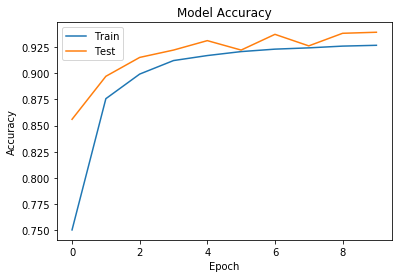

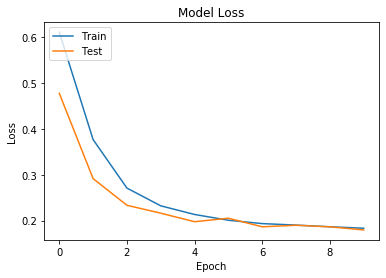

Dev: (6000, 7000), Train: [(0, 6000), (7000, 10000)]
Model: "sequential_27"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_79 (Dense)             (None, 5)                 1505      
_________________________________________________________________
dense_80 (Dense)             (None, 10)                60        
_________________________________________________________________
dense_81 (Dense)             (None, 1)                 11        
Total params: 1,576
Trainable params: 1,576
Non-trainable params: 0
_________________________________________________________________
Train on 9000 samples, validate on 1000 samples
Epoch 1/10
9000/9000 [==============================] - 1s 62us/step - loss: 0.6185 - accuracy: 0.7436 - val_loss: 0.5127 - val_accuracy: 0.8550
Epoch 2/10
9000/9000 [==============================] - 0s 31us/step - loss: 0.4068 - accuracy: 0.8707 - val_loss: 0.3325 - val_accurac

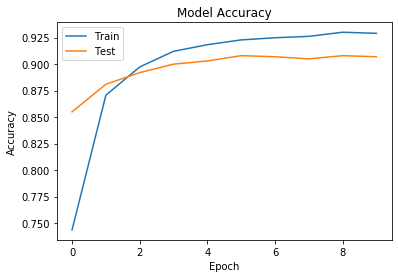

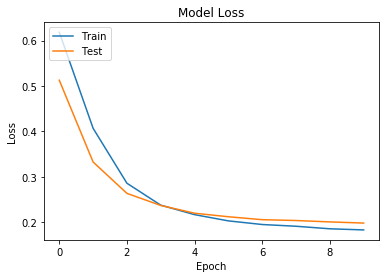

Dev: (7000, 8000), Train: [(0, 7000), (8000, 10000)]
Model: "sequential_28"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_82 (Dense)             (None, 5)                 1505      
_________________________________________________________________
dense_83 (Dense)             (None, 10)                60        
_________________________________________________________________
dense_84 (Dense)             (None, 1)                 11        
Total params: 1,576
Trainable params: 1,576
Non-trainable params: 0
_________________________________________________________________
Train on 9000 samples, validate on 1000 samples
Epoch 1/10
9000/9000 [==============================] - 1s 58us/step - loss: 0.6180 - accuracy: 0.7210 - val_loss: 0.4928 - val_accuracy: 0.8470
Epoch 2/10
9000/9000 [==============================] - 0s 31us/step - loss: 0.3803 - accuracy: 0.8692 - val_loss: 0.3016 - val_accurac

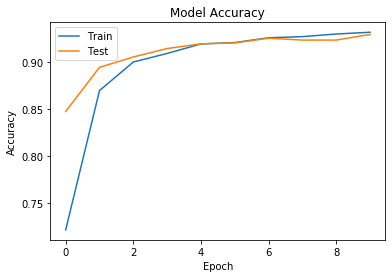

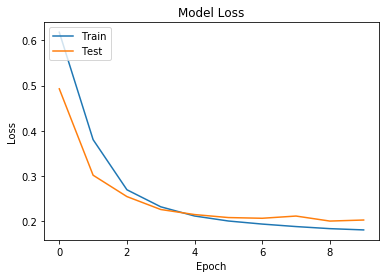

Dev: (8000, 9000), Train: [(0, 8000), (9000, 10000)]
Model: "sequential_29"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_85 (Dense)             (None, 5)                 1505      
_________________________________________________________________
dense_86 (Dense)             (None, 10)                60        
_________________________________________________________________
dense_87 (Dense)             (None, 1)                 11        
Total params: 1,576
Trainable params: 1,576
Non-trainable params: 0
_________________________________________________________________
Train on 9000 samples, validate on 1000 samples
Epoch 1/10
9000/9000 [==============================] - 0s 52us/step - loss: 0.6214 - accuracy: 0.7516 - val_loss: 0.5082 - val_accuracy: 0.8230
Epoch 2/10
9000/9000 [==============================] - 0s 31us/step - loss: 0.3894 - accuracy: 0.8690 - val_loss: 0.3104 - val_accurac

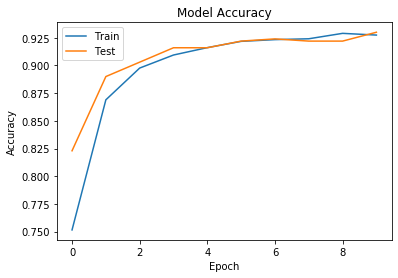

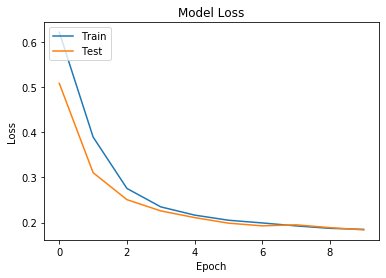

Dev: (9000, 10000), Train: (0, 9000)
Model: "sequential_30"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_88 (Dense)             (None, 5)                 1505      
_________________________________________________________________
dense_89 (Dense)             (None, 10)                60        
_________________________________________________________________
dense_90 (Dense)             (None, 1)                 11        
Total params: 1,576
Trainable params: 1,576
Non-trainable params: 0
_________________________________________________________________
Train on 9000 samples, validate on 1000 samples
Epoch 1/10
9000/9000 [==============================] - 0s 55us/step - loss: 0.5920 - accuracy: 0.7761 - val_loss: 0.4613 - val_accuracy: 0.8390
Epoch 2/10
9000/9000 [==============================] - 0s 31us/step - loss: 0.3724 - accuracy: 0.8754 - val_loss: 0.2869 - val_accuracy: 0.8980
Epoch 

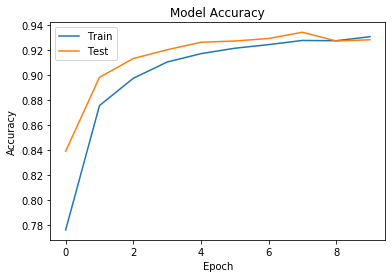

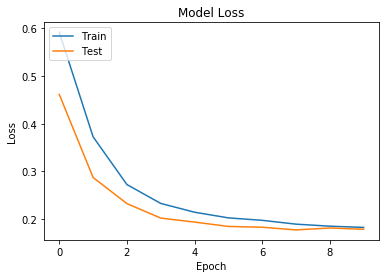

Input Dim: 300, n1: 8, n2: 10, activation: relu, activation_output: sigmoid 

Dev: (0, 1000), Train: (1000, 10000)
Model: "sequential_31"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_91 (Dense)             (None, 8)                 2408      
_________________________________________________________________
dense_92 (Dense)             (None, 10)                90        
_________________________________________________________________
dense_93 (Dense)             (None, 1)                 11        
Total params: 2,509
Trainable params: 2,509
Non-trainable params: 0
_________________________________________________________________
Train on 9000 samples, validate on 1000 samples
Epoch 1/10
9000/9000 [==============================] - 0s 54us/step - loss: 0.6390 - accuracy: 0.7402 - val_loss: 0.5481 - val_accuracy: 0.8240
Epoch 2/10
9000/9000 [==============================] - 0s 31us/step - lo

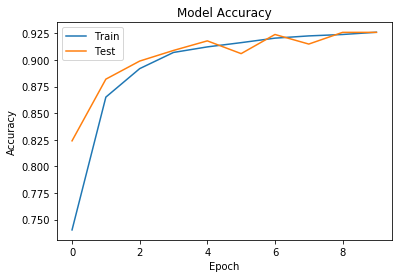

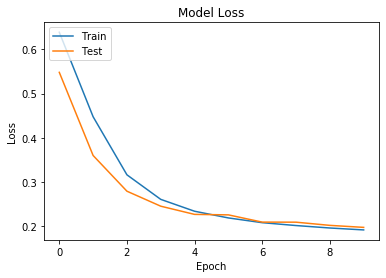

Dev: (1000, 2000), Train: [(0, 1000), (2000, 10000)]
Model: "sequential_32"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_94 (Dense)             (None, 8)                 2408      
_________________________________________________________________
dense_95 (Dense)             (None, 10)                90        
_________________________________________________________________
dense_96 (Dense)             (None, 1)                 11        
Total params: 2,509
Trainable params: 2,509
Non-trainable params: 0
_________________________________________________________________
Train on 9000 samples, validate on 1000 samples
Epoch 1/10
9000/9000 [==============================] - 0s 54us/step - loss: 0.6089 - accuracy: 0.7580 - val_loss: 0.4906 - val_accuracy: 0.8440
Epoch 2/10
9000/9000 [==============================] - 0s 30us/step - loss: 0.3796 - accuracy: 0.8788 - val_loss: 0.3175 - val_accurac

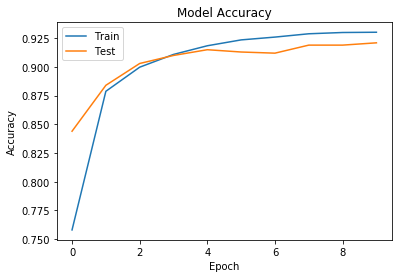

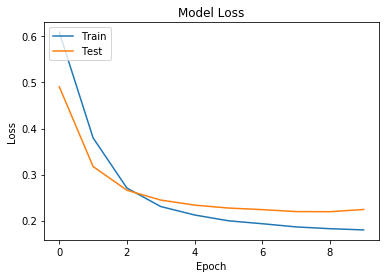

Dev: (2000, 3000), Train: [(0, 2000), (3000, 10000)]
Model: "sequential_33"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_97 (Dense)             (None, 8)                 2408      
_________________________________________________________________
dense_98 (Dense)             (None, 10)                90        
_________________________________________________________________
dense_99 (Dense)             (None, 1)                 11        
Total params: 2,509
Trainable params: 2,509
Non-trainable params: 0
_________________________________________________________________
Train on 9000 samples, validate on 1000 samples
Epoch 1/10
9000/9000 [==============================] - 0s 55us/step - loss: 0.6522 - accuracy: 0.7346 - val_loss: 0.5713 - val_accuracy: 0.8370
Epoch 2/10
9000/9000 [==============================] - 0s 34us/step - loss: 0.4596 - accuracy: 0.8671 - val_loss: 0.3837 - val_accurac

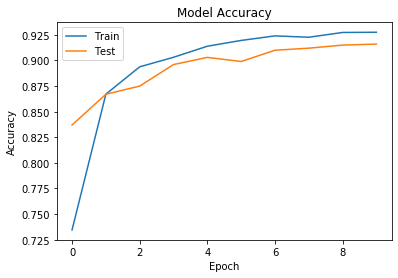

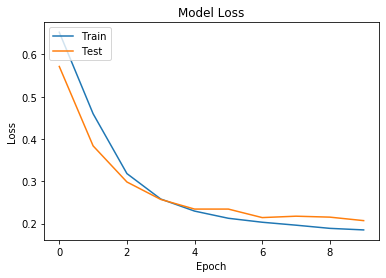

Dev: (3000, 4000), Train: [(0, 3000), (4000, 10000)]
Model: "sequential_34"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_100 (Dense)            (None, 8)                 2408      
_________________________________________________________________
dense_101 (Dense)            (None, 10)                90        
_________________________________________________________________
dense_102 (Dense)            (None, 1)                 11        
Total params: 2,509
Trainable params: 2,509
Non-trainable params: 0
_________________________________________________________________
Train on 9000 samples, validate on 1000 samples
Epoch 1/10
9000/9000 [==============================] - 0s 55us/step - loss: 0.6391 - accuracy: 0.7346 - val_loss: 0.5486 - val_accuracy: 0.8510
Epoch 2/10
9000/9000 [==============================] - 0s 30us/step - loss: 0.4380 - accuracy: 0.8613 - val_loss: 0.3506 - val_accurac

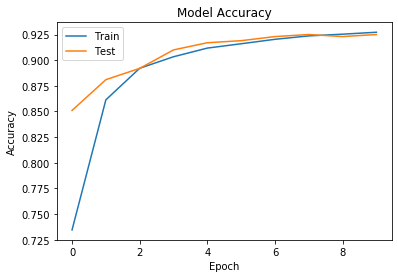

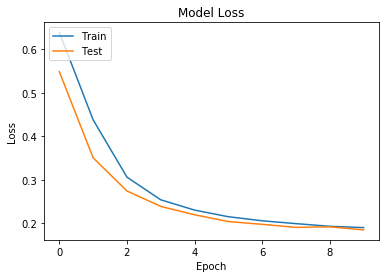

Dev: (4000, 5000), Train: [(0, 4000), (5000, 10000)]
Model: "sequential_35"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_103 (Dense)            (None, 8)                 2408      
_________________________________________________________________
dense_104 (Dense)            (None, 10)                90        
_________________________________________________________________
dense_105 (Dense)            (None, 1)                 11        
Total params: 2,509
Trainable params: 2,509
Non-trainable params: 0
_________________________________________________________________
Train on 9000 samples, validate on 1000 samples
Epoch 1/10
9000/9000 [==============================] - 1s 62us/step - loss: 0.6515 - accuracy: 0.6384 - val_loss: 0.5700 - val_accuracy: 0.8050
Epoch 2/10
9000/9000 [==============================] - 0s 40us/step - loss: 0.4522 - accuracy: 0.8569 - val_loss: 0.3430 - val_accurac

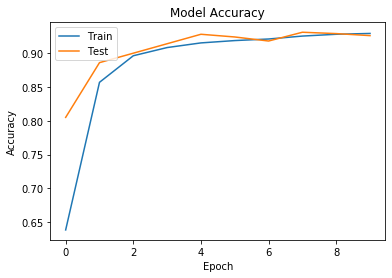

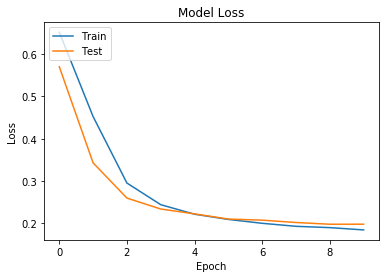

Dev: (5000, 6000), Train: [(0, 5000), (6000, 10000)]
Model: "sequential_36"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_106 (Dense)            (None, 8)                 2408      
_________________________________________________________________
dense_107 (Dense)            (None, 10)                90        
_________________________________________________________________
dense_108 (Dense)            (None, 1)                 11        
Total params: 2,509
Trainable params: 2,509
Non-trainable params: 0
_________________________________________________________________
Train on 9000 samples, validate on 1000 samples
Epoch 1/10
9000/9000 [==============================] - 1s 86us/step - loss: 0.6352 - accuracy: 0.7513 - val_loss: 0.5342 - val_accuracy: 0.8470
Epoch 2/10
9000/9000 [==============================] - 0s 53us/step - loss: 0.4382 - accuracy: 0.8562 - val_loss: 0.3464 - val_accurac

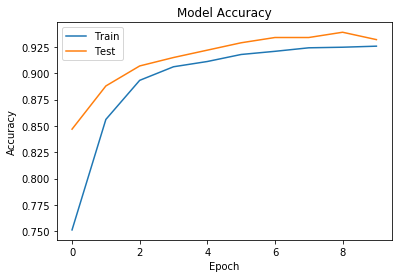

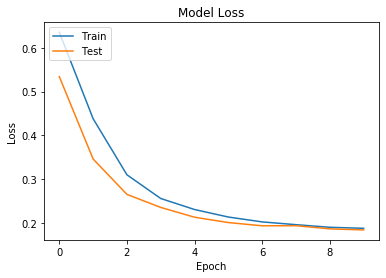

Dev: (6000, 7000), Train: [(0, 6000), (7000, 10000)]
Model: "sequential_37"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_109 (Dense)            (None, 8)                 2408      
_________________________________________________________________
dense_110 (Dense)            (None, 10)                90        
_________________________________________________________________
dense_111 (Dense)            (None, 1)                 11        
Total params: 2,509
Trainable params: 2,509
Non-trainable params: 0
_________________________________________________________________
Train on 9000 samples, validate on 1000 samples
Epoch 1/10
9000/9000 [==============================] - 1s 99us/step - loss: 0.6541 - accuracy: 0.7437 - val_loss: 0.5716 - val_accuracy: 0.8410
Epoch 2/10
9000/9000 [==============================] - 0s 53us/step - loss: 0.4447 - accuracy: 0.8607 - val_loss: 0.3539 - val_accurac

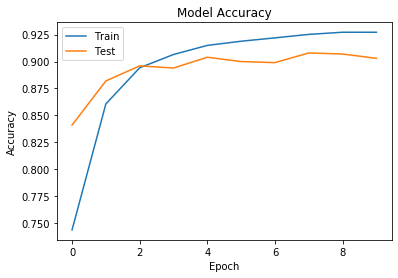

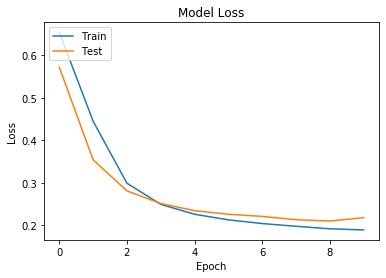

Dev: (7000, 8000), Train: [(0, 7000), (8000, 10000)]
Model: "sequential_38"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_112 (Dense)            (None, 8)                 2408      
_________________________________________________________________
dense_113 (Dense)            (None, 10)                90        
_________________________________________________________________
dense_114 (Dense)            (None, 1)                 11        
Total params: 2,509
Trainable params: 2,509
Non-trainable params: 0
_________________________________________________________________
Train on 9000 samples, validate on 1000 samples
Epoch 1/10
9000/9000 [==============================] - 1s 87us/step - loss: 0.6184 - accuracy: 0.7868 - val_loss: 0.5140 - val_accuracy: 0.8690
Epoch 2/10
9000/9000 [==============================] - 0s 46us/step - loss: 0.4039 - accuracy: 0.8799 - val_loss: 0.3241 - val_accurac

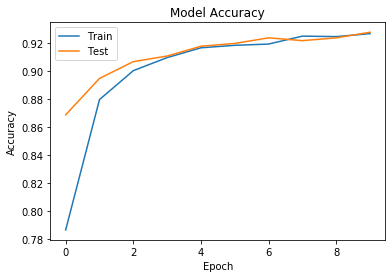

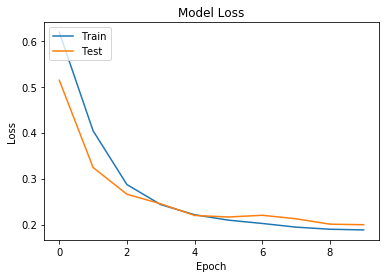

Dev: (8000, 9000), Train: [(0, 8000), (9000, 10000)]
Model: "sequential_39"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_115 (Dense)            (None, 8)                 2408      
_________________________________________________________________
dense_116 (Dense)            (None, 10)                90        
_________________________________________________________________
dense_117 (Dense)            (None, 1)                 11        
Total params: 2,509
Trainable params: 2,509
Non-trainable params: 0
_________________________________________________________________
Train on 9000 samples, validate on 1000 samples
Epoch 1/10
9000/9000 [==============================] - 1s 83us/step - loss: 0.6341 - accuracy: 0.7524 - val_loss: 0.5500 - val_accuracy: 0.8580
Epoch 2/10
9000/9000 [==============================] - 0s 49us/step - loss: 0.4434 - accuracy: 0.8651 - val_loss: 0.3574 - val_accurac

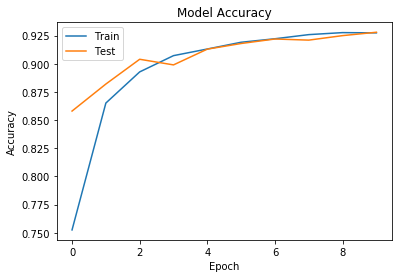

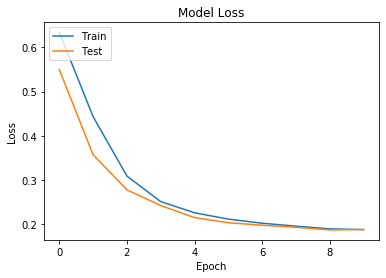

Dev: (9000, 10000), Train: (0, 9000)
Model: "sequential_40"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_118 (Dense)            (None, 8)                 2408      
_________________________________________________________________
dense_119 (Dense)            (None, 10)                90        
_________________________________________________________________
dense_120 (Dense)            (None, 1)                 11        
Total params: 2,509
Trainable params: 2,509
Non-trainable params: 0
_________________________________________________________________
Train on 9000 samples, validate on 1000 samples
Epoch 1/10
9000/9000 [==============================] - 1s 83us/step - loss: 0.6417 - accuracy: 0.6499 - val_loss: 0.5628 - val_accuracy: 0.8000
Epoch 2/10
9000/9000 [==============================] - 0s 42us/step - loss: 0.4765 - accuracy: 0.8520 - val_loss: 0.3890 - val_accuracy: 0.8960
Epoch 

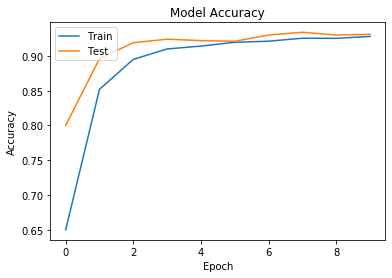

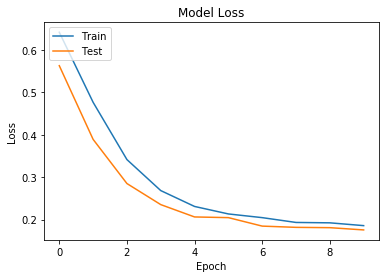

Input Dim: 300, n1: 8, n2: 10, activation: sigmoid, activation_output: sigmoid 

Dev: (0, 1000), Train: (1000, 10000)
Model: "sequential_41"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_121 (Dense)            (None, 8)                 2408      
_________________________________________________________________
dense_122 (Dense)            (None, 10)                90        
_________________________________________________________________
dense_123 (Dense)            (None, 1)                 11        
Total params: 2,509
Trainable params: 2,509
Non-trainable params: 0
_________________________________________________________________
Train on 9000 samples, validate on 1000 samples
Epoch 1/10
9000/9000 [==============================] - 1s 80us/step - loss: 0.6890 - accuracy: 0.5944 - val_loss: 0.6834 - val_accuracy: 0.8060
Epoch 2/10
9000/9000 [==============================] - 0s 50us/step -

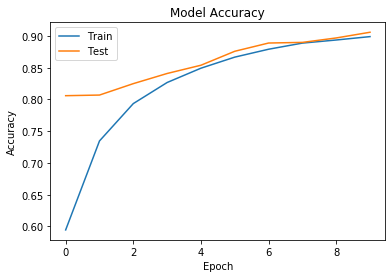

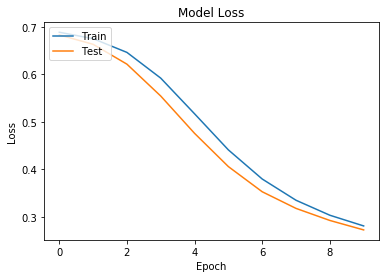

Dev: (1000, 2000), Train: [(0, 1000), (2000, 10000)]
Model: "sequential_42"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_124 (Dense)            (None, 8)                 2408      
_________________________________________________________________
dense_125 (Dense)            (None, 10)                90        
_________________________________________________________________
dense_126 (Dense)            (None, 1)                 11        
Total params: 2,509
Trainable params: 2,509
Non-trainable params: 0
_________________________________________________________________
Train on 9000 samples, validate on 1000 samples
Epoch 1/10
9000/9000 [==============================] - 1s 69us/step - loss: 0.7275 - accuracy: 0.4997 - val_loss: 0.6903 - val_accuracy: 0.5030
Epoch 2/10
9000/9000 [==============================] - 0s 42us/step - loss: 0.6872 - accuracy: 0.6686 - val_loss: 0.6825 - val_accurac

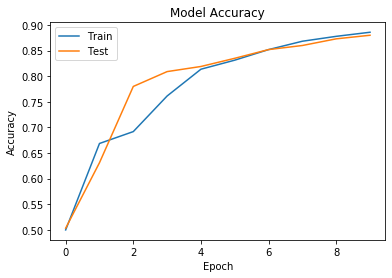

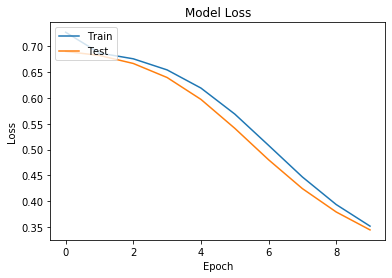

Dev: (2000, 3000), Train: [(0, 2000), (3000, 10000)]
Model: "sequential_43"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_127 (Dense)            (None, 8)                 2408      
_________________________________________________________________
dense_128 (Dense)            (None, 10)                90        
_________________________________________________________________
dense_129 (Dense)            (None, 1)                 11        
Total params: 2,509
Trainable params: 2,509
Non-trainable params: 0
_________________________________________________________________
Train on 9000 samples, validate on 1000 samples
Epoch 1/10
9000/9000 [==============================] - 1s 82us/step - loss: 0.6907 - accuracy: 0.5937 - val_loss: 0.6862 - val_accuracy: 0.6130
Epoch 2/10
9000/9000 [==============================] - 0s 47us/step - loss: 0.6777 - accuracy: 0.6643 - val_loss: 0.6692 - val_accurac

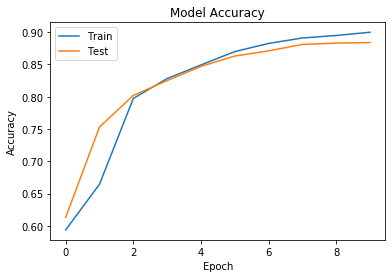

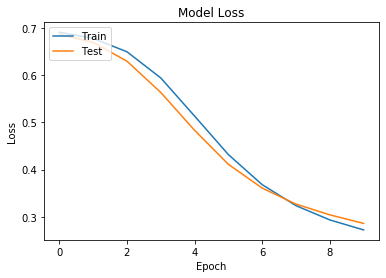

Dev: (3000, 4000), Train: [(0, 3000), (4000, 10000)]
Model: "sequential_44"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_130 (Dense)            (None, 8)                 2408      
_________________________________________________________________
dense_131 (Dense)            (None, 10)                90        
_________________________________________________________________
dense_132 (Dense)            (None, 1)                 11        
Total params: 2,509
Trainable params: 2,509
Non-trainable params: 0
_________________________________________________________________
Train on 9000 samples, validate on 1000 samples
Epoch 1/10
9000/9000 [==============================] - 1s 82us/step - loss: 0.6908 - accuracy: 0.5996 - val_loss: 0.6859 - val_accuracy: 0.7970
Epoch 2/10
9000/9000 [==============================] - 0s 44us/step - loss: 0.6795 - accuracy: 0.7186 - val_loss: 0.6713 - val_accurac

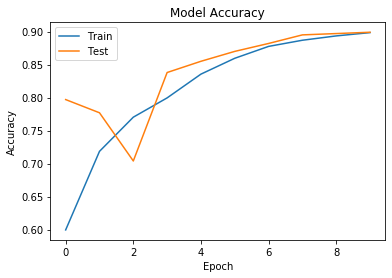

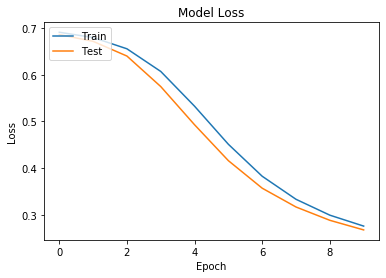

Dev: (4000, 5000), Train: [(0, 4000), (5000, 10000)]
Model: "sequential_45"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_133 (Dense)            (None, 8)                 2408      
_________________________________________________________________
dense_134 (Dense)            (None, 10)                90        
_________________________________________________________________
dense_135 (Dense)            (None, 1)                 11        
Total params: 2,509
Trainable params: 2,509
Non-trainable params: 0
_________________________________________________________________
Train on 9000 samples, validate on 1000 samples
Epoch 1/10
9000/9000 [==============================] - 1s 88us/step - loss: 0.6925 - accuracy: 0.5890 - val_loss: 0.6872 - val_accuracy: 0.5280
Epoch 2/10
9000/9000 [==============================] - 0s 51us/step - loss: 0.6803 - accuracy: 0.7006 - val_loss: 0.6705 - val_accurac

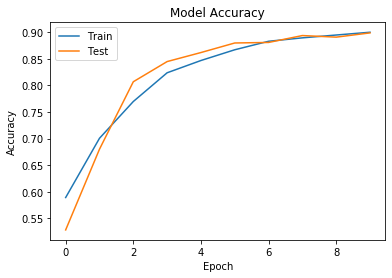

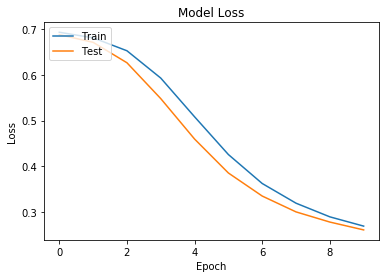

Dev: (5000, 6000), Train: [(0, 5000), (6000, 10000)]
Model: "sequential_46"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_136 (Dense)            (None, 8)                 2408      
_________________________________________________________________
dense_137 (Dense)            (None, 10)                90        
_________________________________________________________________
dense_138 (Dense)            (None, 1)                 11        
Total params: 2,509
Trainable params: 2,509
Non-trainable params: 0
_________________________________________________________________
Train on 9000 samples, validate on 1000 samples
Epoch 1/10
9000/9000 [==============================] - 1s 84us/step - loss: 0.6897 - accuracy: 0.6008 - val_loss: 0.6852 - val_accuracy: 0.7820
Epoch 2/10
9000/9000 [==============================] - 0s 48us/step - loss: 0.6779 - accuracy: 0.7437 - val_loss: 0.6674 - val_accurac

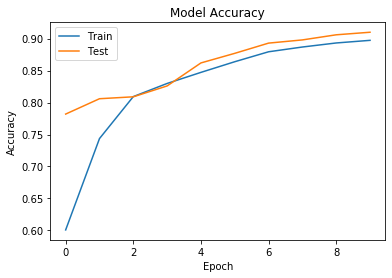

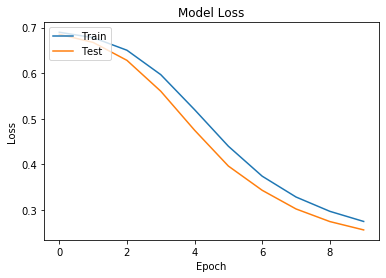

Dev: (6000, 7000), Train: [(0, 6000), (7000, 10000)]
Model: "sequential_47"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_139 (Dense)            (None, 8)                 2408      
_________________________________________________________________
dense_140 (Dense)            (None, 10)                90        
_________________________________________________________________
dense_141 (Dense)            (None, 1)                 11        
Total params: 2,509
Trainable params: 2,509
Non-trainable params: 0
_________________________________________________________________
Train on 9000 samples, validate on 1000 samples
Epoch 1/10
9000/9000 [==============================] - 1s 81us/step - loss: 0.6961 - accuracy: 0.5192 - val_loss: 0.6894 - val_accuracy: 0.7840
Epoch 2/10
9000/9000 [==============================] - 0s 49us/step - loss: 0.6850 - accuracy: 0.6842 - val_loss: 0.6773 - val_accurac

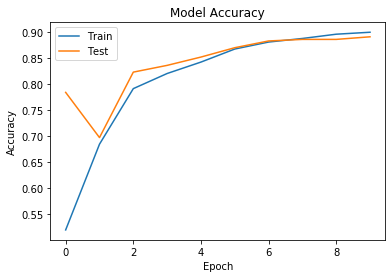

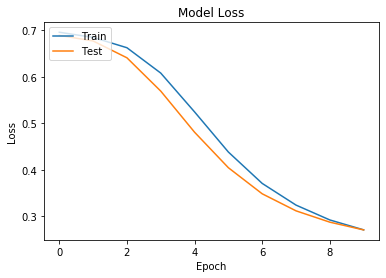

Dev: (7000, 8000), Train: [(0, 7000), (8000, 10000)]
Model: "sequential_48"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_142 (Dense)            (None, 8)                 2408      
_________________________________________________________________
dense_143 (Dense)            (None, 10)                90        
_________________________________________________________________
dense_144 (Dense)            (None, 1)                 11        
Total params: 2,509
Trainable params: 2,509
Non-trainable params: 0
_________________________________________________________________
Train on 9000 samples, validate on 1000 samples
Epoch 1/10
9000/9000 [==============================] - 1s 78us/step - loss: 0.7048 - accuracy: 0.5064 - val_loss: 0.6886 - val_accuracy: 0.5790
Epoch 2/10
9000/9000 [==============================] - 0s 53us/step - loss: 0.6833 - accuracy: 0.6727 - val_loss: 0.6766 - val_accurac

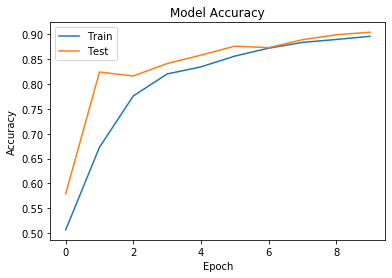

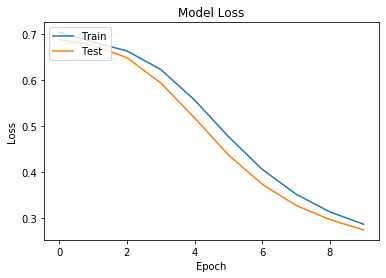

Dev: (8000, 9000), Train: [(0, 8000), (9000, 10000)]
Model: "sequential_49"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_145 (Dense)            (None, 8)                 2408      
_________________________________________________________________
dense_146 (Dense)            (None, 10)                90        
_________________________________________________________________
dense_147 (Dense)            (None, 1)                 11        
Total params: 2,509
Trainable params: 2,509
Non-trainable params: 0
_________________________________________________________________
Train on 9000 samples, validate on 1000 samples
Epoch 1/10
9000/9000 [==============================] - 1s 93us/step - loss: 0.6954 - accuracy: 0.5503 - val_loss: 0.6880 - val_accuracy: 0.4790
Epoch 2/10
9000/9000 [==============================] - 0s 54us/step - loss: 0.6807 - accuracy: 0.7153 - val_loss: 0.6731 - val_accurac

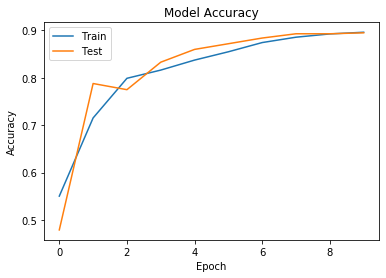

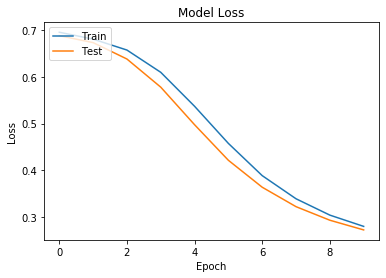

Dev: (9000, 10000), Train: (0, 9000)
Model: "sequential_50"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_148 (Dense)            (None, 8)                 2408      
_________________________________________________________________
dense_149 (Dense)            (None, 10)                90        
_________________________________________________________________
dense_150 (Dense)            (None, 1)                 11        
Total params: 2,509
Trainable params: 2,509
Non-trainable params: 0
_________________________________________________________________
Train on 9000 samples, validate on 1000 samples
Epoch 1/10
9000/9000 [==============================] - 1s 88us/step - loss: 0.6904 - accuracy: 0.5669 - val_loss: 0.6859 - val_accuracy: 0.8090
Epoch 2/10
9000/9000 [==============================] - 0s 53us/step - loss: 0.6790 - accuracy: 0.6542 - val_loss: 0.6671 - val_accuracy: 0.8020
Epoch 

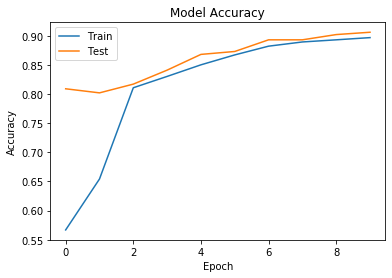

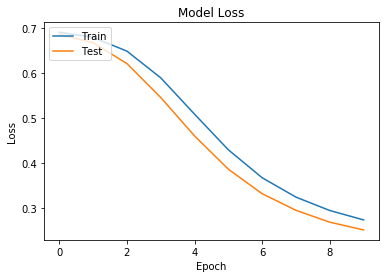

Input Dim: 300, n1: 8, n2: 10, activation: tanh, activation_output: sigmoid 

Dev: (0, 1000), Train: (1000, 10000)
Model: "sequential_51"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_151 (Dense)            (None, 8)                 2408      
_________________________________________________________________
dense_152 (Dense)            (None, 10)                90        
_________________________________________________________________
dense_153 (Dense)            (None, 1)                 11        
Total params: 2,509
Trainable params: 2,509
Non-trainable params: 0
_________________________________________________________________
Train on 9000 samples, validate on 1000 samples
Epoch 1/10
9000/9000 [==============================] - 1s 90us/step - loss: 0.6109 - accuracy: 0.7378 - val_loss: 0.4656 - val_accuracy: 0.8460
Epoch 2/10
9000/9000 [==============================] - 0s 49us/step - lo

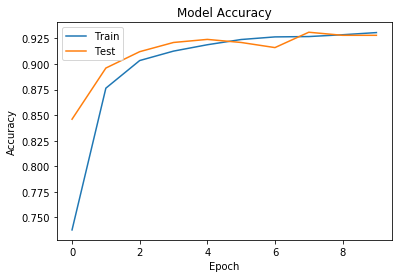

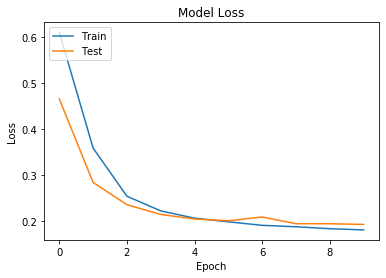

Dev: (1000, 2000), Train: [(0, 1000), (2000, 10000)]
Model: "sequential_52"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_154 (Dense)            (None, 8)                 2408      
_________________________________________________________________
dense_155 (Dense)            (None, 10)                90        
_________________________________________________________________
dense_156 (Dense)            (None, 1)                 11        
Total params: 2,509
Trainable params: 2,509
Non-trainable params: 0
_________________________________________________________________
Train on 9000 samples, validate on 1000 samples
Epoch 1/10
9000/9000 [==============================] - 1s 96us/step - loss: 0.5840 - accuracy: 0.7683 - val_loss: 0.4401 - val_accuracy: 0.8500
Epoch 2/10
9000/9000 [==============================] - 0s 53us/step - loss: 0.3423 - accuracy: 0.8826 - val_loss: 0.2905 - val_accurac

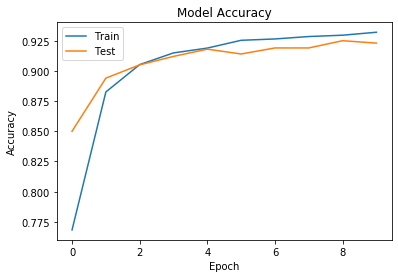

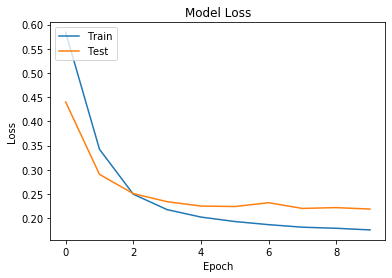

Dev: (2000, 3000), Train: [(0, 2000), (3000, 10000)]
Model: "sequential_53"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_157 (Dense)            (None, 8)                 2408      
_________________________________________________________________
dense_158 (Dense)            (None, 10)                90        
_________________________________________________________________
dense_159 (Dense)            (None, 1)                 11        
Total params: 2,509
Trainable params: 2,509
Non-trainable params: 0
_________________________________________________________________
Train on 9000 samples, validate on 1000 samples
Epoch 1/10
9000/9000 [==============================] - 1s 70us/step - loss: 0.5844 - accuracy: 0.7760 - val_loss: 0.4535 - val_accuracy: 0.8520
Epoch 2/10
9000/9000 [==============================] - 0s 43us/step - loss: 0.3459 - accuracy: 0.8818 - val_loss: 0.2984 - val_accurac

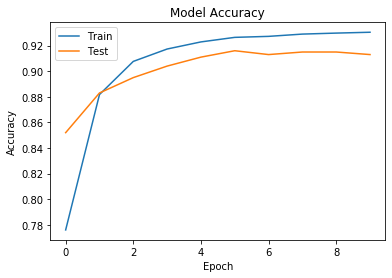

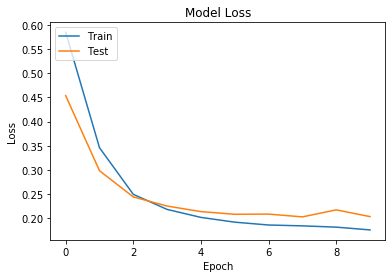

Dev: (3000, 4000), Train: [(0, 3000), (4000, 10000)]
Model: "sequential_54"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_160 (Dense)            (None, 8)                 2408      
_________________________________________________________________
dense_161 (Dense)            (None, 10)                90        
_________________________________________________________________
dense_162 (Dense)            (None, 1)                 11        
Total params: 2,509
Trainable params: 2,509
Non-trainable params: 0
_________________________________________________________________
Train on 9000 samples, validate on 1000 samples
Epoch 1/10
9000/9000 [==============================] - 1s 78us/step - loss: 0.5641 - accuracy: 0.7813 - val_loss: 0.4085 - val_accuracy: 0.8690
Epoch 2/10
9000/9000 [==============================] - 0s 46us/step - loss: 0.3218 - accuracy: 0.8857 - val_loss: 0.2764 - val_accurac

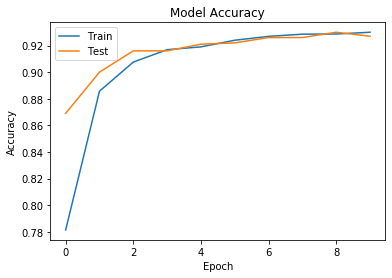

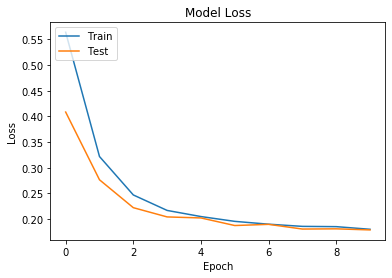

Dev: (4000, 5000), Train: [(0, 4000), (5000, 10000)]
Model: "sequential_55"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_163 (Dense)            (None, 8)                 2408      
_________________________________________________________________
dense_164 (Dense)            (None, 10)                90        
_________________________________________________________________
dense_165 (Dense)            (None, 1)                 11        
Total params: 2,509
Trainable params: 2,509
Non-trainable params: 0
_________________________________________________________________
Train on 9000 samples, validate on 1000 samples
Epoch 1/10
9000/9000 [==============================] - 1s 108us/step - loss: 0.5817 - accuracy: 0.7742 - val_loss: 0.4214 - val_accuracy: 0.8700
Epoch 2/10
9000/9000 [==============================] - 0s 55us/step - loss: 0.3341 - accuracy: 0.8829 - val_loss: 0.2720 - val_accura

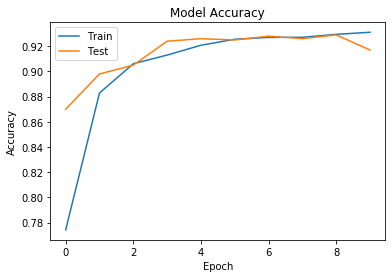

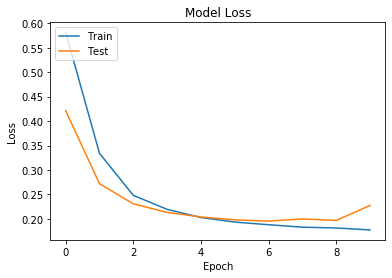

Dev: (5000, 6000), Train: [(0, 5000), (6000, 10000)]
Model: "sequential_56"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_166 (Dense)            (None, 8)                 2408      
_________________________________________________________________
dense_167 (Dense)            (None, 10)                90        
_________________________________________________________________
dense_168 (Dense)            (None, 1)                 11        
Total params: 2,509
Trainable params: 2,509
Non-trainable params: 0
_________________________________________________________________
Train on 9000 samples, validate on 1000 samples
Epoch 1/10
9000/9000 [==============================] - 1s 84us/step - loss: 0.6147 - accuracy: 0.7392 - val_loss: 0.4755 - val_accuracy: 0.8360
Epoch 2/10
9000/9000 [==============================] - 0s 53us/step - loss: 0.3678 - accuracy: 0.8783 - val_loss: 0.2828 - val_accurac

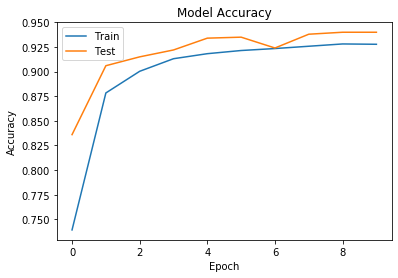

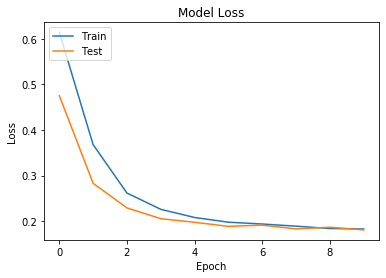

Dev: (6000, 7000), Train: [(0, 6000), (7000, 10000)]
Model: "sequential_57"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_169 (Dense)            (None, 8)                 2408      
_________________________________________________________________
dense_170 (Dense)            (None, 10)                90        
_________________________________________________________________
dense_171 (Dense)            (None, 1)                 11        
Total params: 2,509
Trainable params: 2,509
Non-trainable params: 0
_________________________________________________________________
Train on 9000 samples, validate on 1000 samples
Epoch 1/10
9000/9000 [==============================] - 1s 70us/step - loss: 0.6092 - accuracy: 0.7546 - val_loss: 0.4702 - val_accuracy: 0.8370
Epoch 2/10
9000/9000 [==============================] - 0s 45us/step - loss: 0.3561 - accuracy: 0.8751 - val_loss: 0.2997 - val_accurac

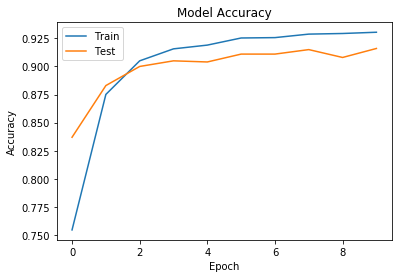

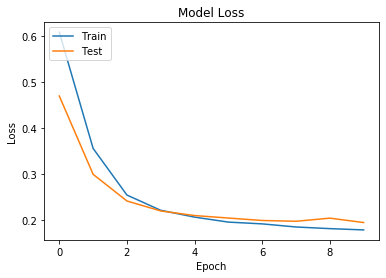

Dev: (7000, 8000), Train: [(0, 7000), (8000, 10000)]
Model: "sequential_58"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_172 (Dense)            (None, 8)                 2408      
_________________________________________________________________
dense_173 (Dense)            (None, 10)                90        
_________________________________________________________________
dense_174 (Dense)            (None, 1)                 11        
Total params: 2,509
Trainable params: 2,509
Non-trainable params: 0
_________________________________________________________________
Train on 9000 samples, validate on 1000 samples
Epoch 1/10
9000/9000 [==============================] - 1s 79us/step - loss: 0.6191 - accuracy: 0.7686 - val_loss: 0.4845 - val_accuracy: 0.8430
Epoch 2/10
9000/9000 [==============================] - 0s 43us/step - loss: 0.3703 - accuracy: 0.8752 - val_loss: 0.2975 - val_accurac

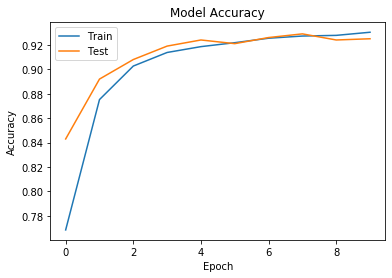

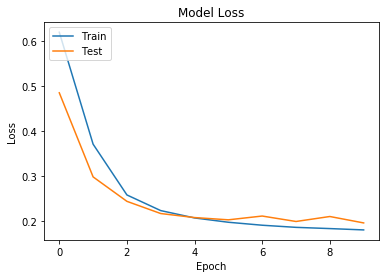

Dev: (8000, 9000), Train: [(0, 8000), (9000, 10000)]
Model: "sequential_59"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_175 (Dense)            (None, 8)                 2408      
_________________________________________________________________
dense_176 (Dense)            (None, 10)                90        
_________________________________________________________________
dense_177 (Dense)            (None, 1)                 11        
Total params: 2,509
Trainable params: 2,509
Non-trainable params: 0
_________________________________________________________________
Train on 9000 samples, validate on 1000 samples
Epoch 1/10
9000/9000 [==============================] - 1s 73us/step - loss: 0.5679 - accuracy: 0.7873 - val_loss: 0.4272 - val_accuracy: 0.8120
Epoch 2/10
9000/9000 [==============================] - 0s 46us/step - loss: 0.3277 - accuracy: 0.8838 - val_loss: 0.2739 - val_accurac

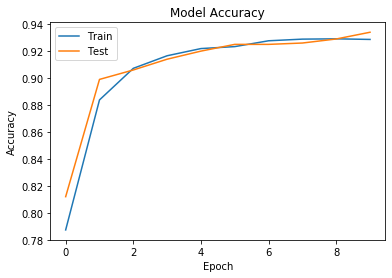

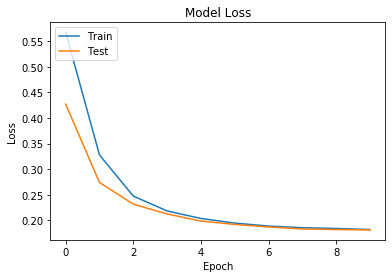

Dev: (9000, 10000), Train: (0, 9000)
Model: "sequential_60"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_178 (Dense)            (None, 8)                 2408      
_________________________________________________________________
dense_179 (Dense)            (None, 10)                90        
_________________________________________________________________
dense_180 (Dense)            (None, 1)                 11        
Total params: 2,509
Trainable params: 2,509
Non-trainable params: 0
_________________________________________________________________
Train on 9000 samples, validate on 1000 samples
Epoch 1/10
9000/9000 [==============================] - 1s 96us/step - loss: 0.5717 - accuracy: 0.7876 - val_loss: 0.4140 - val_accuracy: 0.8470
Epoch 2/10
9000/9000 [==============================] - 1s 57us/step - loss: 0.3308 - accuracy: 0.8836 - val_loss: 0.2600 - val_accuracy: 0.9050
Epoch 

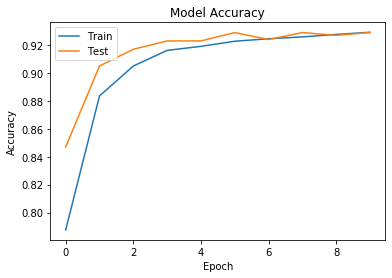

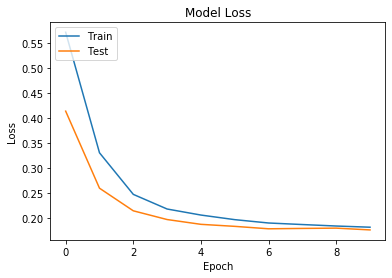

Input Dim: 300, n1: 10, n2: 10, activation: relu, activation_output: sigmoid 

Dev: (0, 1000), Train: (1000, 10000)
Model: "sequential_61"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_181 (Dense)            (None, 10)                3010      
_________________________________________________________________
dense_182 (Dense)            (None, 10)                110       
_________________________________________________________________
dense_183 (Dense)            (None, 1)                 11        
Total params: 3,131
Trainable params: 3,131
Non-trainable params: 0
_________________________________________________________________
Train on 9000 samples, validate on 1000 samples
Epoch 1/10
9000/9000 [==============================] - 1s 85us/step - loss: 0.6478 - accuracy: 0.6381 - val_loss: 0.5697 - val_accuracy: 0.7690
Epoch 2/10
9000/9000 [==============================] - 0s 53us/step - l

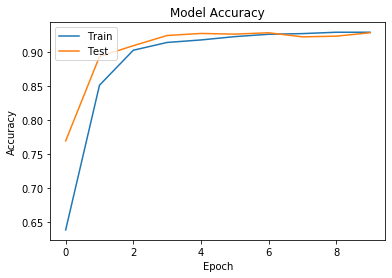

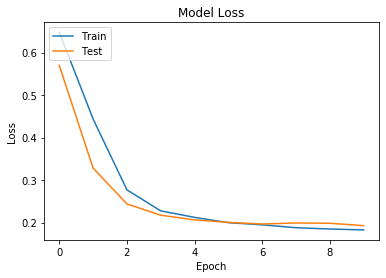

Dev: (1000, 2000), Train: [(0, 1000), (2000, 10000)]
Model: "sequential_62"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_184 (Dense)            (None, 10)                3010      
_________________________________________________________________
dense_185 (Dense)            (None, 10)                110       
_________________________________________________________________
dense_186 (Dense)            (None, 1)                 11        
Total params: 3,131
Trainable params: 3,131
Non-trainable params: 0
_________________________________________________________________
Train on 9000 samples, validate on 1000 samples
Epoch 1/10
9000/9000 [==============================] - 1s 82us/step - loss: 0.6564 - accuracy: 0.6367 - val_loss: 0.5825 - val_accuracy: 0.7930
Epoch 2/10
9000/9000 [==============================] - 0s 48us/step - loss: 0.4597 - accuracy: 0.8676 - val_loss: 0.3595 - val_accurac

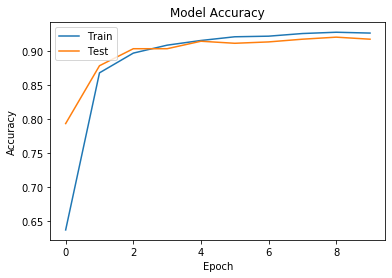

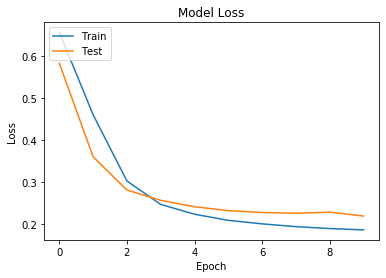

Dev: (2000, 3000), Train: [(0, 2000), (3000, 10000)]
Model: "sequential_63"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_187 (Dense)            (None, 10)                3010      
_________________________________________________________________
dense_188 (Dense)            (None, 10)                110       
_________________________________________________________________
dense_189 (Dense)            (None, 1)                 11        
Total params: 3,131
Trainable params: 3,131
Non-trainable params: 0
_________________________________________________________________
Train on 9000 samples, validate on 1000 samples
Epoch 1/10
9000/9000 [==============================] - 1s 83us/step - loss: 0.6534 - accuracy: 0.7088 - val_loss: 0.5757 - val_accuracy: 0.8150
Epoch 2/10
9000/9000 [==============================] - 0s 51us/step - loss: 0.4627 - accuracy: 0.8572 - val_loss: 0.3781 - val_accurac

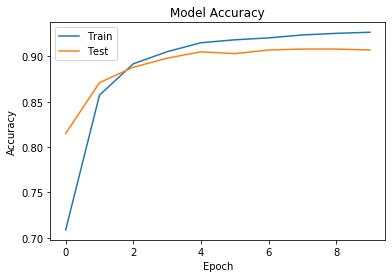

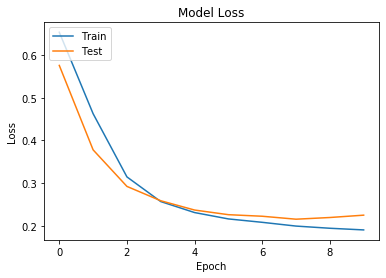

Dev: (3000, 4000), Train: [(0, 3000), (4000, 10000)]
Model: "sequential_64"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_190 (Dense)            (None, 10)                3010      
_________________________________________________________________
dense_191 (Dense)            (None, 10)                110       
_________________________________________________________________
dense_192 (Dense)            (None, 1)                 11        
Total params: 3,131
Trainable params: 3,131
Non-trainable params: 0
_________________________________________________________________
Train on 9000 samples, validate on 1000 samples
Epoch 1/10
9000/9000 [==============================] - 1s 79us/step - loss: 0.6197 - accuracy: 0.7517 - val_loss: 0.4998 - val_accuracy: 0.8630
Epoch 2/10
9000/9000 [==============================] - 0s 45us/step - loss: 0.3860 - accuracy: 0.8766 - val_loss: 0.3073 - val_accurac

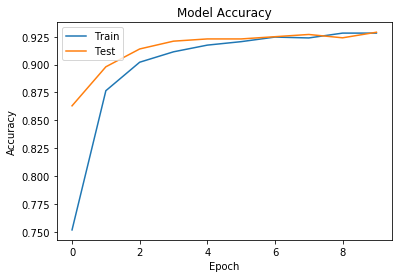

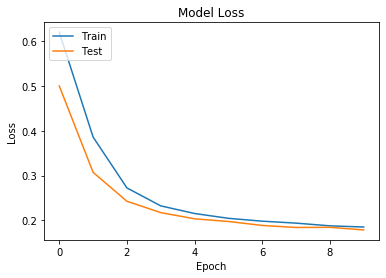

Dev: (4000, 5000), Train: [(0, 4000), (5000, 10000)]
Model: "sequential_65"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_193 (Dense)            (None, 10)                3010      
_________________________________________________________________
dense_194 (Dense)            (None, 10)                110       
_________________________________________________________________
dense_195 (Dense)            (None, 1)                 11        
Total params: 3,131
Trainable params: 3,131
Non-trainable params: 0
_________________________________________________________________
Train on 9000 samples, validate on 1000 samples
Epoch 1/10
9000/9000 [==============================] - 1s 75us/step - loss: 0.6083 - accuracy: 0.7831 - val_loss: 0.4812 - val_accuracy: 0.8480
Epoch 2/10
9000/9000 [==============================] - 0s 45us/step - loss: 0.3831 - accuracy: 0.8757 - val_loss: 0.3091 - val_accurac

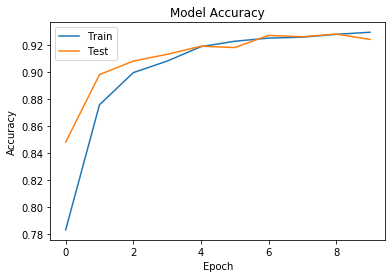

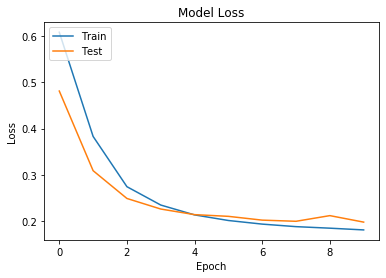

Dev: (5000, 6000), Train: [(0, 5000), (6000, 10000)]
Model: "sequential_66"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_196 (Dense)            (None, 10)                3010      
_________________________________________________________________
dense_197 (Dense)            (None, 10)                110       
_________________________________________________________________
dense_198 (Dense)            (None, 1)                 11        
Total params: 3,131
Trainable params: 3,131
Non-trainable params: 0
_________________________________________________________________
Train on 9000 samples, validate on 1000 samples
Epoch 1/10
9000/9000 [==============================] - 1s 87us/step - loss: 0.6265 - accuracy: 0.7561 - val_loss: 0.5264 - val_accuracy: 0.8560
Epoch 2/10
9000/9000 [==============================] - 0s 43us/step - loss: 0.4283 - accuracy: 0.8711 - val_loss: 0.3439 - val_accurac

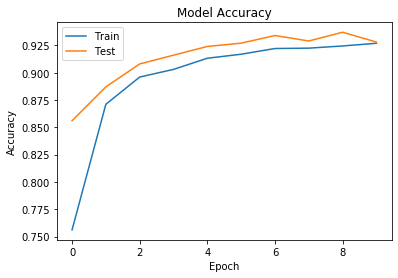

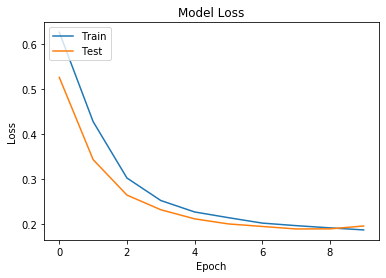

Dev: (6000, 7000), Train: [(0, 6000), (7000, 10000)]
Model: "sequential_67"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_199 (Dense)            (None, 10)                3010      
_________________________________________________________________
dense_200 (Dense)            (None, 10)                110       
_________________________________________________________________
dense_201 (Dense)            (None, 1)                 11        
Total params: 3,131
Trainable params: 3,131
Non-trainable params: 0
_________________________________________________________________
Train on 9000 samples, validate on 1000 samples
Epoch 1/10
9000/9000 [==============================] - 1s 76us/step - loss: 0.6711 - accuracy: 0.5897 - val_loss: 0.6244 - val_accuracy: 0.6980
Epoch 2/10
9000/9000 [==============================] - 0s 43us/step - loss: 0.5549 - accuracy: 0.7824 - val_loss: 0.4731 - val_accurac

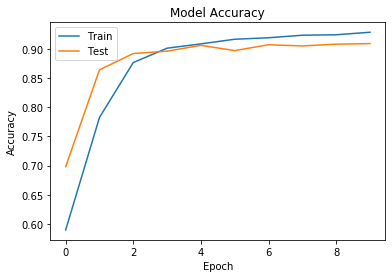

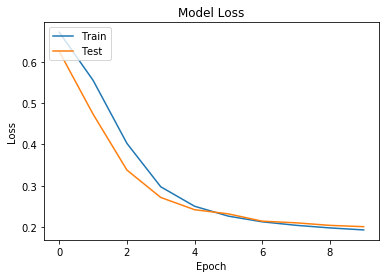

Dev: (7000, 8000), Train: [(0, 7000), (8000, 10000)]
Model: "sequential_68"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_202 (Dense)            (None, 10)                3010      
_________________________________________________________________
dense_203 (Dense)            (None, 10)                110       
_________________________________________________________________
dense_204 (Dense)            (None, 1)                 11        
Total params: 3,131
Trainable params: 3,131
Non-trainable params: 0
_________________________________________________________________
Train on 9000 samples, validate on 1000 samples
Epoch 1/10
9000/9000 [==============================] - 1s 68us/step - loss: 0.6375 - accuracy: 0.7611 - val_loss: 0.5340 - val_accuracy: 0.8050
Epoch 2/10
9000/9000 [==============================] - 0s 48us/step - loss: 0.4199 - accuracy: 0.8684 - val_loss: 0.3255 - val_accurac

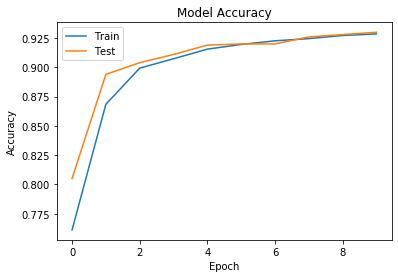

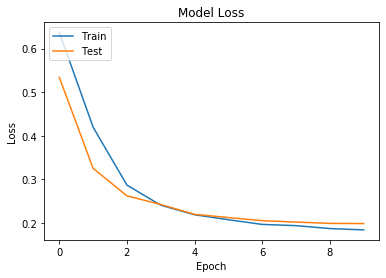

Dev: (8000, 9000), Train: [(0, 8000), (9000, 10000)]
Model: "sequential_69"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_205 (Dense)            (None, 10)                3010      
_________________________________________________________________
dense_206 (Dense)            (None, 10)                110       
_________________________________________________________________
dense_207 (Dense)            (None, 1)                 11        
Total params: 3,131
Trainable params: 3,131
Non-trainable params: 0
_________________________________________________________________
Train on 9000 samples, validate on 1000 samples
Epoch 1/10
9000/9000 [==============================] - 1s 74us/step - loss: 0.6054 - accuracy: 0.7892 - val_loss: 0.4763 - val_accuracy: 0.8580
Epoch 2/10
9000/9000 [==============================] - 0s 44us/step - loss: 0.3703 - accuracy: 0.8798 - val_loss: 0.2958 - val_accurac

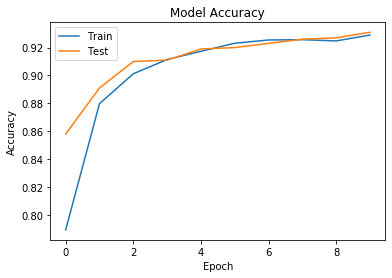

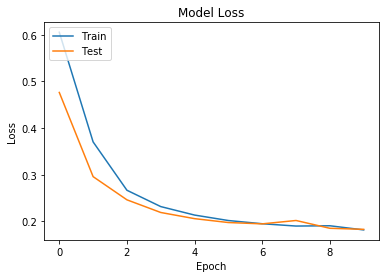

Dev: (9000, 10000), Train: (0, 9000)
Model: "sequential_70"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_208 (Dense)            (None, 10)                3010      
_________________________________________________________________
dense_209 (Dense)            (None, 10)                110       
_________________________________________________________________
dense_210 (Dense)            (None, 1)                 11        
Total params: 3,131
Trainable params: 3,131
Non-trainable params: 0
_________________________________________________________________
Train on 9000 samples, validate on 1000 samples
Epoch 1/10
9000/9000 [==============================] - 1s 72us/step - loss: 0.6064 - accuracy: 0.7584 - val_loss: 0.4919 - val_accuracy: 0.8740
Epoch 2/10
9000/9000 [==============================] - 0s 44us/step - loss: 0.3980 - accuracy: 0.8811 - val_loss: 0.3019 - val_accuracy: 0.9050
Epoch 

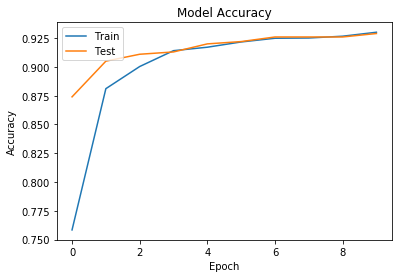

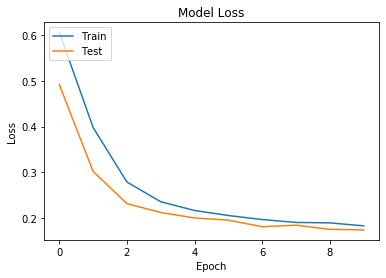

Input Dim: 300, n1: 10, n2: 10, activation: sigmoid, activation_output: sigmoid 

Dev: (0, 1000), Train: (1000, 10000)
Model: "sequential_71"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_211 (Dense)            (None, 10)                3010      
_________________________________________________________________
dense_212 (Dense)            (None, 10)                110       
_________________________________________________________________
dense_213 (Dense)            (None, 1)                 11        
Total params: 3,131
Trainable params: 3,131
Non-trainable params: 0
_________________________________________________________________
Train on 9000 samples, validate on 1000 samples
Epoch 1/10
9000/9000 [==============================] - 1s 75us/step - loss: 0.6879 - accuracy: 0.5980 - val_loss: 0.6804 - val_accuracy: 0.7680
Epoch 2/10
9000/9000 [==============================] - 0s 45us/step 

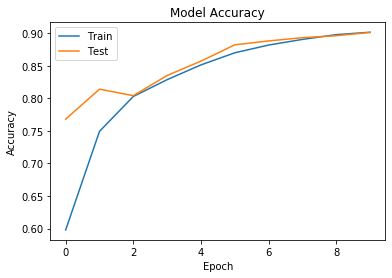

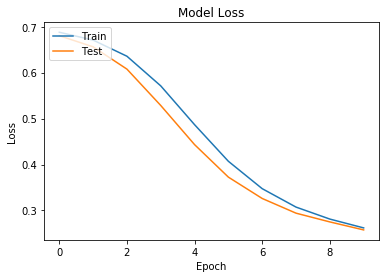

Dev: (1000, 2000), Train: [(0, 1000), (2000, 10000)]
Model: "sequential_72"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_214 (Dense)            (None, 10)                3010      
_________________________________________________________________
dense_215 (Dense)            (None, 10)                110       
_________________________________________________________________
dense_216 (Dense)            (None, 1)                 11        
Total params: 3,131
Trainable params: 3,131
Non-trainable params: 0
_________________________________________________________________
Train on 9000 samples, validate on 1000 samples
Epoch 1/10
9000/9000 [==============================] - 1s 87us/step - loss: 0.6897 - accuracy: 0.6310 - val_loss: 0.6814 - val_accuracy: 0.8150
Epoch 2/10
9000/9000 [==============================] - 1s 62us/step - loss: 0.6716 - accuracy: 0.7256 - val_loss: 0.6587 - val_accurac

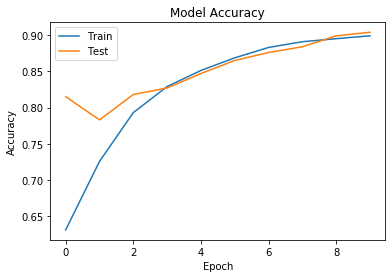

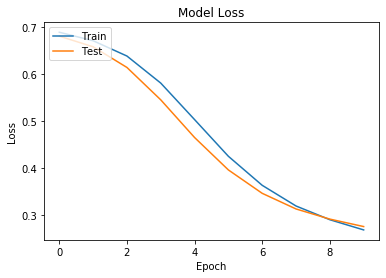

Dev: (2000, 3000), Train: [(0, 2000), (3000, 10000)]
Model: "sequential_73"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_217 (Dense)            (None, 10)                3010      
_________________________________________________________________
dense_218 (Dense)            (None, 10)                110       
_________________________________________________________________
dense_219 (Dense)            (None, 1)                 11        
Total params: 3,131
Trainable params: 3,131
Non-trainable params: 0
_________________________________________________________________
Train on 9000 samples, validate on 1000 samples
Epoch 1/10
9000/9000 [==============================] - 1s 111us/step - loss: 0.7068 - accuracy: 0.5342 - val_loss: 0.6867 - val_accuracy: 0.7150
Epoch 2/10
9000/9000 [==============================] - 0s 39us/step - loss: 0.6811 - accuracy: 0.7540 - val_loss: 0.6743 - val_accura

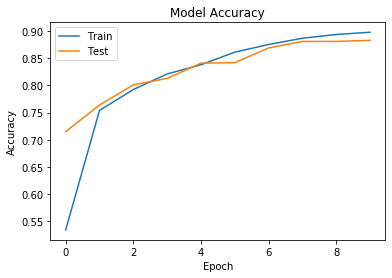

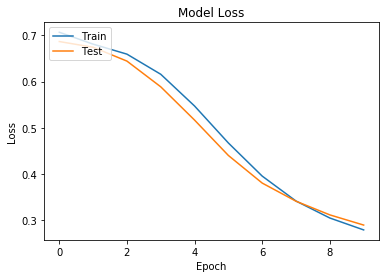

Dev: (3000, 4000), Train: [(0, 3000), (4000, 10000)]
Model: "sequential_74"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_220 (Dense)            (None, 10)                3010      
_________________________________________________________________
dense_221 (Dense)            (None, 10)                110       
_________________________________________________________________
dense_222 (Dense)            (None, 1)                 11        
Total params: 3,131
Trainable params: 3,131
Non-trainable params: 0
_________________________________________________________________
Train on 9000 samples, validate on 1000 samples
Epoch 1/10
9000/9000 [==============================] - 1s 71us/step - loss: 0.7002 - accuracy: 0.5002 - val_loss: 0.6889 - val_accuracy: 0.5720
Epoch 2/10
9000/9000 [==============================] - 0s 40us/step - loss: 0.6850 - accuracy: 0.7427 - val_loss: 0.6796 - val_accurac

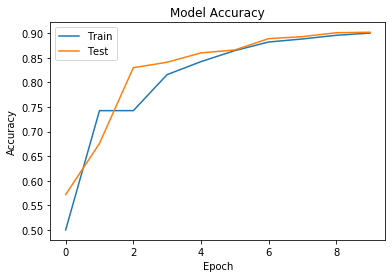

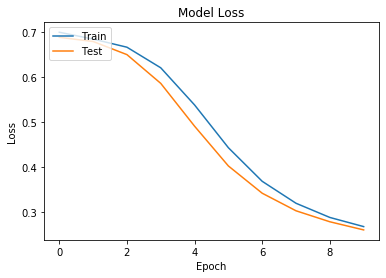

Dev: (4000, 5000), Train: [(0, 4000), (5000, 10000)]
Model: "sequential_75"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_223 (Dense)            (None, 10)                3010      
_________________________________________________________________
dense_224 (Dense)            (None, 10)                110       
_________________________________________________________________
dense_225 (Dense)            (None, 1)                 11        
Total params: 3,131
Trainable params: 3,131
Non-trainable params: 0
_________________________________________________________________
Train on 9000 samples, validate on 1000 samples
Epoch 1/10
9000/9000 [==============================] - 1s 70us/step - loss: 0.6925 - accuracy: 0.5307 - val_loss: 0.6896 - val_accuracy: 0.5580
Epoch 2/10
9000/9000 [==============================] - 0s 44us/step - loss: 0.6847 - accuracy: 0.6630 - val_loss: 0.6774 - val_accurac

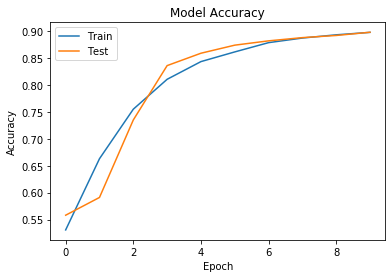

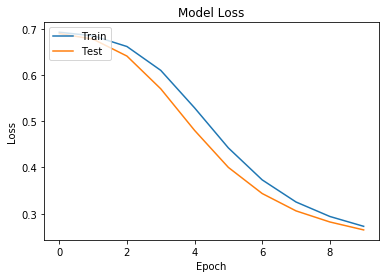

Dev: (5000, 6000), Train: [(0, 5000), (6000, 10000)]
Model: "sequential_76"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_226 (Dense)            (None, 10)                3010      
_________________________________________________________________
dense_227 (Dense)            (None, 10)                110       
_________________________________________________________________
dense_228 (Dense)            (None, 1)                 11        
Total params: 3,131
Trainable params: 3,131
Non-trainable params: 0
_________________________________________________________________
Train on 9000 samples, validate on 1000 samples
Epoch 1/10
9000/9000 [==============================] - 1s 78us/step - loss: 0.7002 - accuracy: 0.5347 - val_loss: 0.6892 - val_accuracy: 0.7860
Epoch 2/10
9000/9000 [==============================] - 0s 40us/step - loss: 0.6850 - accuracy: 0.7000 - val_loss: 0.6771 - val_accurac

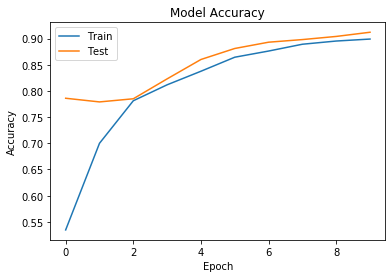

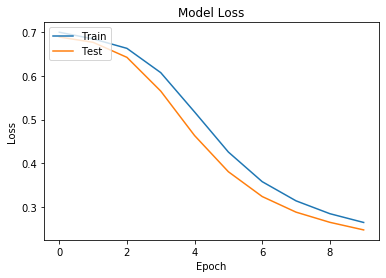

Dev: (6000, 7000), Train: [(0, 6000), (7000, 10000)]
Model: "sequential_77"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_229 (Dense)            (None, 10)                3010      
_________________________________________________________________
dense_230 (Dense)            (None, 10)                110       
_________________________________________________________________
dense_231 (Dense)            (None, 1)                 11        
Total params: 3,131
Trainable params: 3,131
Non-trainable params: 0
_________________________________________________________________
Train on 9000 samples, validate on 1000 samples
Epoch 1/10
9000/9000 [==============================] - 1s 83us/step - loss: 0.6930 - accuracy: 0.5560 - val_loss: 0.6826 - val_accuracy: 0.5820
Epoch 2/10
9000/9000 [==============================] - 0s 44us/step - loss: 0.6742 - accuracy: 0.7380 - val_loss: 0.6629 - val_accurac

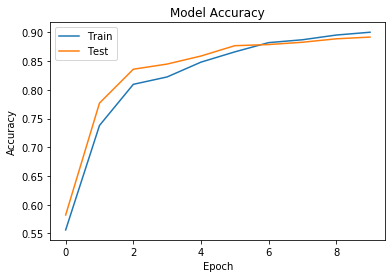

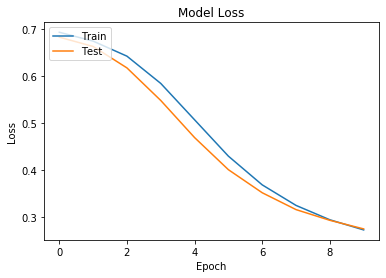

Dev: (7000, 8000), Train: [(0, 7000), (8000, 10000)]
Model: "sequential_78"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_232 (Dense)            (None, 10)                3010      
_________________________________________________________________
dense_233 (Dense)            (None, 10)                110       
_________________________________________________________________
dense_234 (Dense)            (None, 1)                 11        
Total params: 3,131
Trainable params: 3,131
Non-trainable params: 0
_________________________________________________________________
Train on 9000 samples, validate on 1000 samples
Epoch 1/10
9000/9000 [==============================] - 1s 80us/step - loss: 0.7680 - accuracy: 0.5028 - val_loss: 0.7070 - val_accuracy: 0.4750
Epoch 2/10
9000/9000 [==============================] - 0s 42us/step - loss: 0.6918 - accuracy: 0.5029 - val_loss: 0.6887 - val_accurac

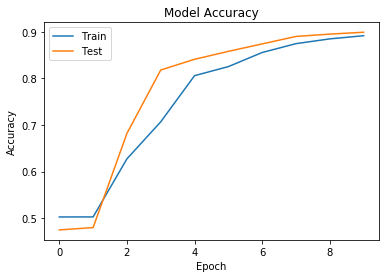

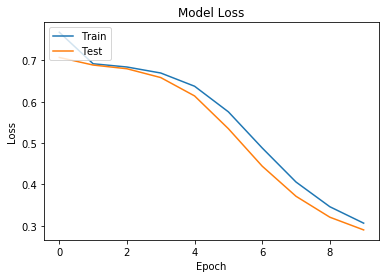

Dev: (8000, 9000), Train: [(0, 8000), (9000, 10000)]
Model: "sequential_79"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_235 (Dense)            (None, 10)                3010      
_________________________________________________________________
dense_236 (Dense)            (None, 10)                110       
_________________________________________________________________
dense_237 (Dense)            (None, 1)                 11        
Total params: 3,131
Trainable params: 3,131
Non-trainable params: 0
_________________________________________________________________
Train on 9000 samples, validate on 1000 samples
Epoch 1/10
9000/9000 [==============================] - 1s 65us/step - loss: 0.7208 - accuracy: 0.5024 - val_loss: 0.6903 - val_accuracy: 0.4870
Epoch 2/10
9000/9000 [==============================] - 0s 42us/step - loss: 0.6852 - accuracy: 0.5930 - val_loss: 0.6796 - val_accurac

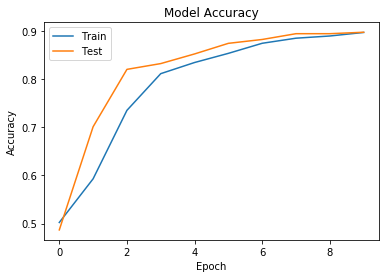

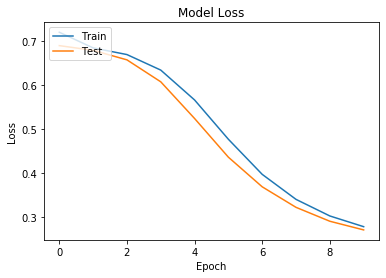

Dev: (9000, 10000), Train: (0, 9000)
Model: "sequential_80"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_238 (Dense)            (None, 10)                3010      
_________________________________________________________________
dense_239 (Dense)            (None, 10)                110       
_________________________________________________________________
dense_240 (Dense)            (None, 1)                 11        
Total params: 3,131
Trainable params: 3,131
Non-trainable params: 0
_________________________________________________________________
Train on 9000 samples, validate on 1000 samples
Epoch 1/10
9000/9000 [==============================] - 1s 71us/step - loss: 0.7070 - accuracy: 0.5073 - val_loss: 0.6886 - val_accuracy: 0.5030
Epoch 2/10
9000/9000 [==============================] - 0s 39us/step - loss: 0.6826 - accuracy: 0.6888 - val_loss: 0.6753 - val_accuracy: 0.7290
Epoch 

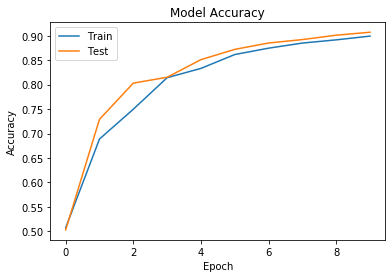

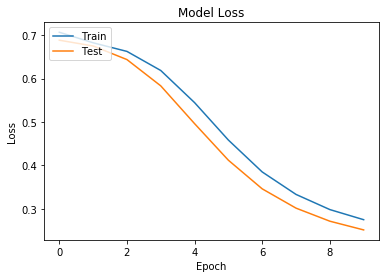

Input Dim: 300, n1: 10, n2: 10, activation: tanh, activation_output: sigmoid 

Dev: (0, 1000), Train: (1000, 10000)
Model: "sequential_81"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_241 (Dense)            (None, 10)                3010      
_________________________________________________________________
dense_242 (Dense)            (None, 10)                110       
_________________________________________________________________
dense_243 (Dense)            (None, 1)                 11        
Total params: 3,131
Trainable params: 3,131
Non-trainable params: 0
_________________________________________________________________
Train on 9000 samples, validate on 1000 samples
Epoch 1/10
9000/9000 [==============================] - 1s 73us/step - loss: 0.5949 - accuracy: 0.7646 - val_loss: 0.4431 - val_accuracy: 0.8580
Epoch 2/10
9000/9000 [==============================] - 0s 39us/step - l

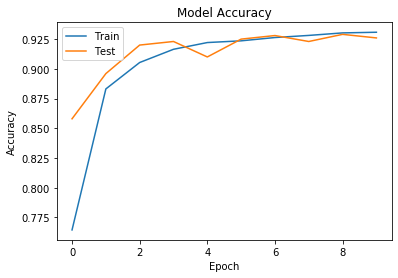

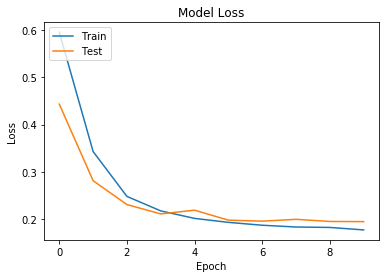

Dev: (1000, 2000), Train: [(0, 1000), (2000, 10000)]
Model: "sequential_82"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_244 (Dense)            (None, 10)                3010      
_________________________________________________________________
dense_245 (Dense)            (None, 10)                110       
_________________________________________________________________
dense_246 (Dense)            (None, 1)                 11        
Total params: 3,131
Trainable params: 3,131
Non-trainable params: 0
_________________________________________________________________
Train on 9000 samples, validate on 1000 samples
Epoch 1/10
9000/9000 [==============================] - 0s 48us/step - loss: 0.5866 - accuracy: 0.7604 - val_loss: 0.4337 - val_accuracy: 0.8590
Epoch 2/10
9000/9000 [==============================] - 0s 30us/step - loss: 0.3292 - accuracy: 0.8853 - val_loss: 0.2873 - val_accurac

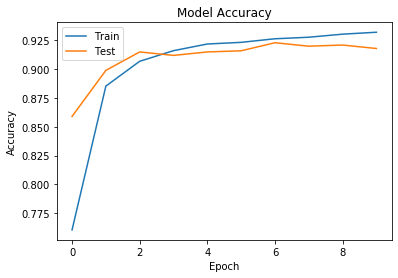

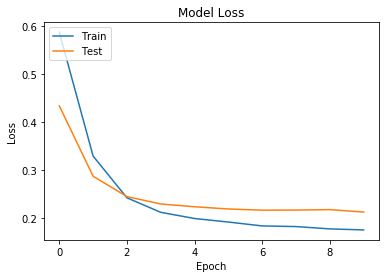

Dev: (2000, 3000), Train: [(0, 2000), (3000, 10000)]
Model: "sequential_83"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_247 (Dense)            (None, 10)                3010      
_________________________________________________________________
dense_248 (Dense)            (None, 10)                110       
_________________________________________________________________
dense_249 (Dense)            (None, 1)                 11        
Total params: 3,131
Trainable params: 3,131
Non-trainable params: 0
_________________________________________________________________
Train on 9000 samples, validate on 1000 samples
Epoch 1/10
9000/9000 [==============================] - 0s 48us/step - loss: 0.5786 - accuracy: 0.7690 - val_loss: 0.4292 - val_accuracy: 0.8460
Epoch 2/10
9000/9000 [==============================] - 0s 29us/step - loss: 0.3243 - accuracy: 0.8861 - val_loss: 0.2840 - val_accurac

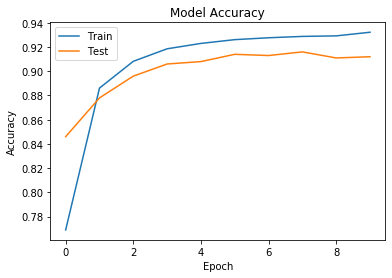

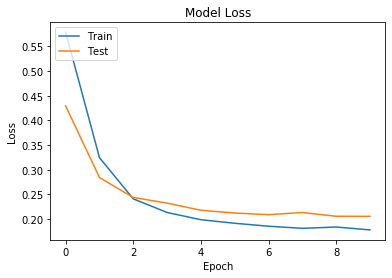

Dev: (3000, 4000), Train: [(0, 3000), (4000, 10000)]
Model: "sequential_84"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_250 (Dense)            (None, 10)                3010      
_________________________________________________________________
dense_251 (Dense)            (None, 10)                110       
_________________________________________________________________
dense_252 (Dense)            (None, 1)                 11        
Total params: 3,131
Trainable params: 3,131
Non-trainable params: 0
_________________________________________________________________
Train on 9000 samples, validate on 1000 samples
Epoch 1/10
9000/9000 [==============================] - 1s 71us/step - loss: 0.6010 - accuracy: 0.7469 - val_loss: 0.4494 - val_accuracy: 0.8500
Epoch 2/10
9000/9000 [==============================] - 0s 40us/step - loss: 0.3411 - accuracy: 0.8801 - val_loss: 0.2731 - val_accurac

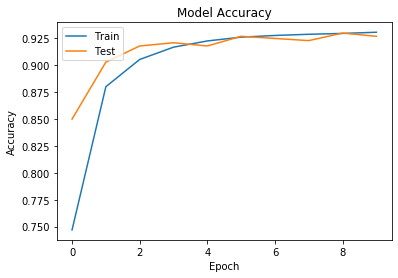

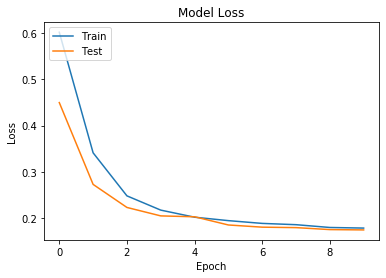

Dev: (4000, 5000), Train: [(0, 4000), (5000, 10000)]
Model: "sequential_85"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_253 (Dense)            (None, 10)                3010      
_________________________________________________________________
dense_254 (Dense)            (None, 10)                110       
_________________________________________________________________
dense_255 (Dense)            (None, 1)                 11        
Total params: 3,131
Trainable params: 3,131
Non-trainable params: 0
_________________________________________________________________
Train on 9000 samples, validate on 1000 samples
Epoch 1/10
9000/9000 [==============================] - 1s 63us/step - loss: 0.5696 - accuracy: 0.7762 - val_loss: 0.4095 - val_accuracy: 0.8630
Epoch 2/10
9000/9000 [==============================] - 0s 36us/step - loss: 0.3229 - accuracy: 0.8891 - val_loss: 0.2631 - val_accurac

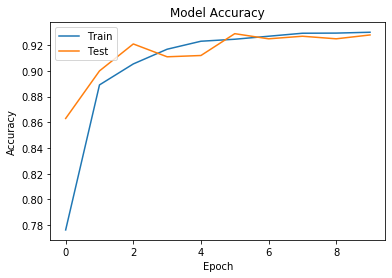

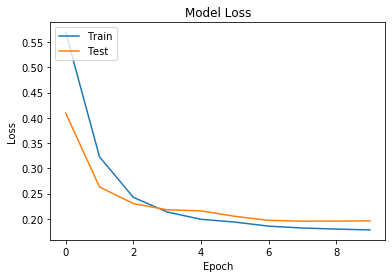

Dev: (5000, 6000), Train: [(0, 5000), (6000, 10000)]
Model: "sequential_86"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_256 (Dense)            (None, 10)                3010      
_________________________________________________________________
dense_257 (Dense)            (None, 10)                110       
_________________________________________________________________
dense_258 (Dense)            (None, 1)                 11        
Total params: 3,131
Trainable params: 3,131
Non-trainable params: 0
_________________________________________________________________
Train on 9000 samples, validate on 1000 samples
Epoch 1/10
9000/9000 [==============================] - 1s 69us/step - loss: 0.5828 - accuracy: 0.7544 - val_loss: 0.4229 - val_accuracy: 0.8570
Epoch 2/10
9000/9000 [==============================] - 0s 32us/step - loss: 0.3294 - accuracy: 0.8847 - val_loss: 0.2697 - val_accurac

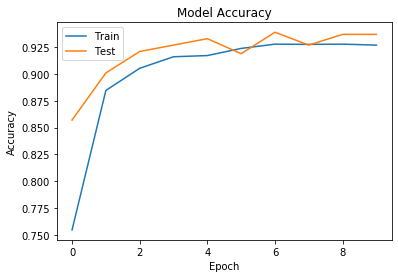

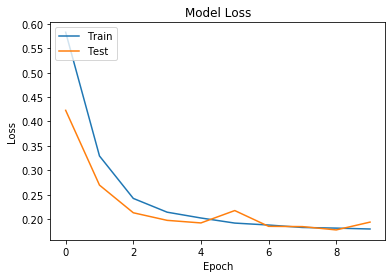

Dev: (6000, 7000), Train: [(0, 6000), (7000, 10000)]
Model: "sequential_87"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_259 (Dense)            (None, 10)                3010      
_________________________________________________________________
dense_260 (Dense)            (None, 10)                110       
_________________________________________________________________
dense_261 (Dense)            (None, 1)                 11        
Total params: 3,131
Trainable params: 3,131
Non-trainable params: 0
_________________________________________________________________
Train on 9000 samples, validate on 1000 samples
Epoch 1/10
9000/9000 [==============================] - 1s 62us/step - loss: 0.5841 - accuracy: 0.7553 - val_loss: 0.4304 - val_accuracy: 0.8580
Epoch 2/10
9000/9000 [==============================] - 0s 31us/step - loss: 0.3353 - accuracy: 0.8789 - val_loss: 0.2824 - val_accurac

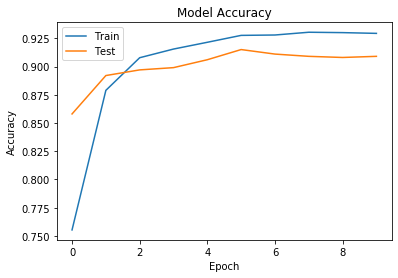

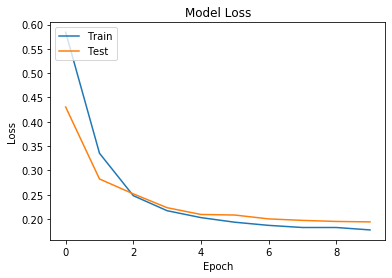

Dev: (7000, 8000), Train: [(0, 7000), (8000, 10000)]
Model: "sequential_88"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_262 (Dense)            (None, 10)                3010      
_________________________________________________________________
dense_263 (Dense)            (None, 10)                110       
_________________________________________________________________
dense_264 (Dense)            (None, 1)                 11        
Total params: 3,131
Trainable params: 3,131
Non-trainable params: 0
_________________________________________________________________
Train on 9000 samples, validate on 1000 samples
Epoch 1/10
9000/9000 [==============================] - 1s 74us/step - loss: 0.6016 - accuracy: 0.7203 - val_loss: 0.4461 - val_accuracy: 0.8680
Epoch 2/10
9000/9000 [==============================] - 0s 42us/step - loss: 0.3406 - accuracy: 0.8827 - val_loss: 0.2754 - val_accurac

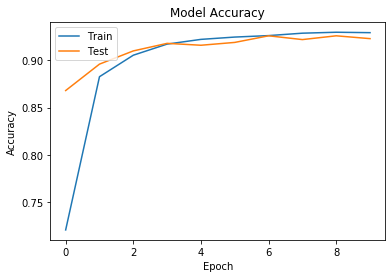

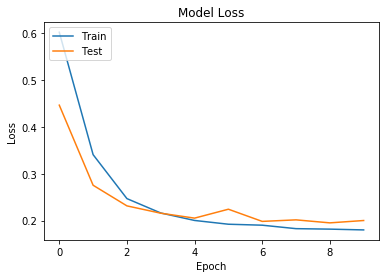

Dev: (8000, 9000), Train: [(0, 8000), (9000, 10000)]
Model: "sequential_89"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_265 (Dense)            (None, 10)                3010      
_________________________________________________________________
dense_266 (Dense)            (None, 10)                110       
_________________________________________________________________
dense_267 (Dense)            (None, 1)                 11        
Total params: 3,131
Trainable params: 3,131
Non-trainable params: 0
_________________________________________________________________
Train on 9000 samples, validate on 1000 samples
Epoch 1/10
9000/9000 [==============================] - 1s 72us/step - loss: 0.5969 - accuracy: 0.7344 - val_loss: 0.4415 - val_accuracy: 0.8660
Epoch 2/10
9000/9000 [==============================] - 0s 37us/step - loss: 0.3351 - accuracy: 0.8814 - val_loss: 0.2771 - val_accurac

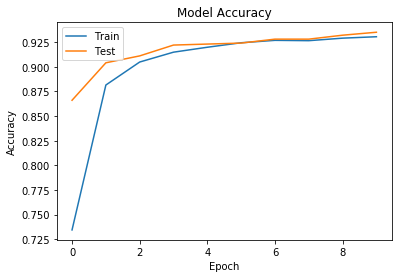

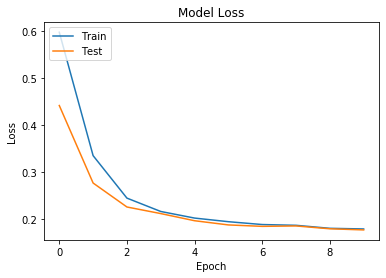

Dev: (9000, 10000), Train: (0, 9000)
Model: "sequential_90"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_268 (Dense)            (None, 10)                3010      
_________________________________________________________________
dense_269 (Dense)            (None, 10)                110       
_________________________________________________________________
dense_270 (Dense)            (None, 1)                 11        
Total params: 3,131
Trainable params: 3,131
Non-trainable params: 0
_________________________________________________________________
Train on 9000 samples, validate on 1000 samples
Epoch 1/10
9000/9000 [==============================] - 1s 66us/step - loss: 0.5714 - accuracy: 0.7803 - val_loss: 0.4104 - val_accuracy: 0.8620
Epoch 2/10
9000/9000 [==============================] - 0s 38us/step - loss: 0.3294 - accuracy: 0.8846 - val_loss: 0.2542 - val_accuracy: 0.9030
Epoch 

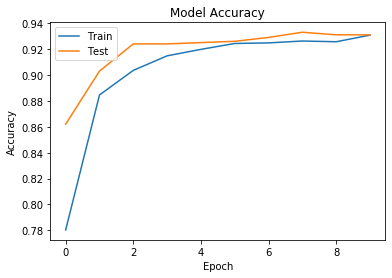

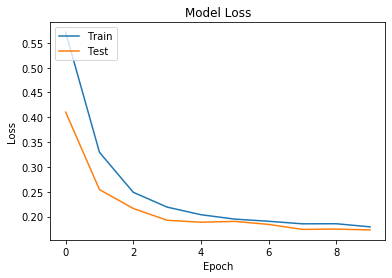

Model: "sequential_91"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_271 (Dense)            (None, 8)                 2408      
_________________________________________________________________
dense_272 (Dense)            (None, 10)                90        
_________________________________________________________________
dense_273 (Dense)            (None, 1)                 11        
Total params: 2,509
Trainable params: 2,509
Non-trainable params: 0
_________________________________________________________________
Validation/Test set is not given
Epoch 1/10
10000/10000 [==============================] - 1s 66us/step - loss: 0.5797 - accuracy: 0.7893
Epoch 2/10
10000/10000 [==============================] - 0s 34us/step - loss: 0.3205 - accuracy: 0.8904
Epoch 3/10
10000/10000 [==============================] - 0s 31us/step - loss: 0.2414 - accuracy: 0.9073
Epoch 4/10
10000/10000 [=========

In [20]:
run_3_3(word_2_vec_model, train_data, train_labels)